# Clustering on DeepFold Embeddings
Haerang Lee

I'm going to take Skyler's DeepFold embeddings. Those files are in `embeddings/DeepFold` in the GCS bucket.

Then let me run some clustering models on top of it.

**Silly question**: If I want to put this notebook under a directory, how do I access `utils` in the parent directory? Right now I just put my notebook in the home dir.

In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs

In [624]:
# Get all the keys from gcs
allkeys = gcs.list_keys()

In [625]:
# What's in here?
allkeys[0:10]

['/annotations/blast_annotations.csv',
 'UP000005640_9606_HUMAN.tar',
 'UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RBG1-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A024RCN7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H5-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H7-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H8-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6H9-F1-model_v1.cif.gz',
 'UP000005640_9606_HUMAN/cif/AF-A0A075B6I0-F1-model_v1.cif.gz']

In [626]:
# How many files are there?
len(allkeys)

46838

In [627]:
# I just want the DeepFold embedding files
for k in allkeys:
    if "embed" in k:
        print(k)

embeddings/
embeddings/DeepFold/
embeddings/DeepFold/embeddings_0.csv
embeddings/DeepFold/embeddings_1.csv
embeddings/DeepFold/embeddings_10.csv
embeddings/DeepFold/embeddings_11.csv
embeddings/DeepFold/embeddings_12.csv
embeddings/DeepFold/embeddings_13.csv
embeddings/DeepFold/embeddings_14.csv
embeddings/DeepFold/embeddings_15.csv
embeddings/DeepFold/embeddings_16.csv
embeddings/DeepFold/embeddings_17.csv
embeddings/DeepFold/embeddings_18.csv
embeddings/DeepFold/embeddings_19.csv
embeddings/DeepFold/embeddings_2.csv
embeddings/DeepFold/embeddings_20.csv
embeddings/DeepFold/embeddings_3.csv
embeddings/DeepFold/embeddings_4.csv
embeddings/DeepFold/embeddings_5.csv
embeddings/DeepFold/embeddings_6.csv
embeddings/DeepFold/embeddings_7.csv
embeddings/DeepFold/embeddings_8.csv
embeddings/DeepFold/embeddings_9.csv


In [628]:
prefix = 'embeddings/DeepFold'
keys = gcs.list_file_paths(prefix)

There are 21 files in the embeddings folder, each containing 1,000 proteins (except the last one). Here are the file names.

In [629]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_1.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_11.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_12.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_13.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_14.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_15.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_16.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_17.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_18.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_19.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_2.csv',
 'gs://capstone-fall21-pro

One of those embeddings files contains 1,000 proteins.
The first three elements appear to be empty data, or just `'', '0', '1\n0'`. The remaining 2,000 are pairs of protein name and relevant embedding (2\*1000).

In [630]:
keys[1]

'gs://capstone-fall21-protein/embeddings/DeepFold/embeddings_0.csv'

In [632]:
key = gcs.uri_to_bucket_and_key(keys[2])[1]
key

'embeddings/DeepFold/embeddings_1.csv'

## Download and Parse DeepFold Embeddings

In [637]:
# Let me download one and play with it.
df_emb = gcs.download_text(key)

In [638]:
# Decode it then split it into a list.
df_emb_decode = df_emb.split(",")

In [639]:
# 1002 items, where the first few are not just metadata or empty strings
len(df_emb_decode)

1002

In [641]:
# Item index 2 is where the real data starts. That's the protein name.
df_emb_decode[0:2]

['protein_id', 'deepfold\nQ13200']

In [642]:
df_emb_decode[3]

'"[5.96747687e-03 0.00000000e+00 1.85894519e-02 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 1.58412028e-02 6.06489480e-02\n 1.20269276e-01 0.00000000e+00 1.09242159e-03 0.00000000e+00\n 3.65636125e-02 2.16107760e-02 0.00000000e+00 2.00002007e-02\n 0.00000000e+00 2.02822257e-02 4.80303104e-04 0.00000000e+00\n 1.04048893e-01 0.00000000e+00 3.60421650e-02 4.14775945e-02\n 1.24980044e-02 0.00000000e+00 6.08191919e-03 1.06642962e-01\n 2.12292913e-02 3.20112929e-02 9.43305343e-03 7.48014897e-02\n 0.00000000e+00 0.00000000e+00 2.28349902e-02 0.00000000e+00\n 7.61815533e-03 1.36520118e-01 1.64051410e-02 0.00000000e+00\n 8.02622437e-02 0.00000000e+00 4.27073240e-02 2.12408379e-02\n 9.43467468e-02 0.00000000e+00 2.17287447e-02 0.00000000e+00\n 3.11355650e-01 0.00000000e+00 1.02889389e-01 0.00000000e+00\n 1.73968710e-02 0.00000000e+00 0.00000000e+00 2.08255574e-02\n 8.63376930e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 3.49744782e-02 2.44668610e-02 0.00000000e+00 8.66087794e-04\n 0.000

In [643]:
# Let's figure out how to parse the DeepFold embedding. 
# There's a lot of funny stuff in here.
# First, get rid of the file number at the end and just keep the vector

sample_emb = df_emb_decode[3].rsplit('\n', 1)[0]

In [648]:
sample_emb[0:40]

'"[5.96747687e-03 0.00000000e+00 1.858945'

In [651]:
# Now get rid of the double quotes and brackets to just get the values of the array

sample_emb_np = np.array(sample_emb[2:-2].split()).astype(float)
sample_emb_np

array([5.96747687e-03, 0.00000000e+00, 1.85894519e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.58412028e-02, 6.06489480e-02,
       1.20269276e-01, 0.00000000e+00, 1.09242159e-03, 0.00000000e+00,
       3.65636125e-02, 2.16107760e-02, 0.00000000e+00, 2.00002007e-02,
       0.00000000e+00, 2.02822257e-02, 4.80303104e-04, 0.00000000e+00,
       1.04048893e-01, 0.00000000e+00, 3.60421650e-02, 4.14775945e-02,
       1.24980044e-02, 0.00000000e+00, 6.08191919e-03, 1.06642962e-01,
       2.12292913e-02, 3.20112929e-02, 9.43305343e-03, 7.48014897e-02,
       0.00000000e+00, 0.00000000e+00, 2.28349902e-02, 0.00000000e+00,
       7.61815533e-03, 1.36520118e-01, 1.64051410e-02, 0.00000000e+00,
       8.02622437e-02, 0.00000000e+00, 4.27073240e-02, 2.12408379e-02,
       9.43467468e-02, 0.00000000e+00, 2.17287447e-02, 0.00000000e+00,
       3.11355650e-01, 0.00000000e+00, 1.02889389e-01, 0.00000000e+00,
       1.73968710e-02, 0.00000000e+00, 0.00000000e+00, 2.08255574e-02,
      

In [652]:
# Size is as expected 

sample_emb_np.shape

(398,)

In [686]:
len(sample_emb_np)

398

In [851]:
sum(sample_emb_np == 0)

194

In [696]:
def protein_file_processor(key):
    i = 2
    X = np.empty((0,398), dtype=float)
    protein = np.empty((0,1), dtype=str)

    df_emb_decode = gcs.download_text(key).decode('utf-8').split(",")    
    
    # If any embedding hasn't been generated, then put it into missing 
    missing_protein=[]

    while i < len(df_emb_decode):
        pair = df_emb_decode[i].rsplit('\n', 1)
        # parse feature vec. Remove double quotes and brackets. Split and cast as float.
        feature_vec = np.array(pair[0][2:-2].split()).astype(float)
        protein_id = pair[1]

        # Only take the vector if we have a feature vec of length 398 
        if len(feature_vec) != 398:
            missing_protein.append(protein_id)
            i+=1
            continue

        X = np.concatenate((X, feature_vec.reshape(1,398)))
        protein = np.append(protein, protein_id)
        i+=1
    
    return X, protein, missing_protein 


In [743]:
X, protein, missing_protein = protein_file_processor(key)

In [744]:
print(X.shape)
print(protein.shape)
print(len(missing_protein))

(991, 398)
(991,)
9


# Clustering

In [699]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=5).fit(X)

In [700]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[ -1 540]
 [  0 405]
 [  1  19]
 [  2  17]
 [  3   5]]


---

# Hyperparam tuning

Next steps for me:
1. I’m going to add in some form of evaluation metrics. Exploring using BLAST or other more traditional cluster evaluation techniques like the Elbow method. Then I’ll try to figure out what a reasonable outcome means and how to optimize for it.
1. I’ll write the code to tune the hyperparams.
1. Finally, I am going to write a .py file to download all the proteins and run a DB scan on all the proteins, then tune the hyperparams.

## Ideal number of clusters for the data


DBSCAN takes two inputs: `eps` and `min_samples`. Since this is an unsupervised model, here are some validity functions I can use to determine the right hyperparam values. 

First, let me try the Silhouette coefficient.

In [701]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [702]:
# Let's just use my data from above, where the size is 987.
range_min_samples = range(5, 200, 5)

for n in range_min_samples:
    clustering = DBSCAN(eps=1, min_samples=n).fit(X)
    cluster_labels = clustering.labels_
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("min_samples = " + str(n) + ":", str(silhouette_avg))
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

min_samples = 5: 0.15547580995368857
min_samples = 10: 0.15951951421274593
min_samples = 15: 0.16128840631626357
min_samples = 20: 0.16178131410768568
min_samples = 25: 0.16224428994449333
min_samples = 30: 0.16224428994449333
min_samples = 35: 0.16224428994449333
min_samples = 40: 0.16224428994449333
min_samples = 45: 0.16140126621833725
min_samples = 50: 0.16140126621833725
min_samples = 55: 0.1607021447052012
min_samples = 60: 0.161718420016649
min_samples = 65: 0.16189488788086173
min_samples = 70: 0.16173836322297142
min_samples = 75: 0.16173836322297142
min_samples = 80: 0.16173836322297142
min_samples = 85: 0.16185411745587697
min_samples = 90: 0.16185411745587697
min_samples = 95: 0.16185411745587697
min_samples = 100: 0.16185411745587697
min_samples = 105: 0.16240360182963584
min_samples = 110: 0.16206755944009069
min_samples = 115: 0.16206755944009069
min_samples = 120: 0.16206755944009069
min_samples = 125: 0.16206755944009069
min_samples = 130: 0.16145426704572186
min_sampl

In [703]:
sample_silhouette_values.shape

(986,)

## Euclidean distances between points

The parameter `eps` in DBSCAN represents the distance threshold below which the two points are considered neighbors to each other. I have no idea what the range of distances look like, so let me find out. 

A thorough way to do this is to find out the distance between every point and every other point. Given I have 1,000 points, I'll get 1,000^2 distances. It's OK to do with 1,000 points but may cause an issue with 23,000. We'll see.

Let me do the proper way first. Then, if I need to optimize it later, I'll sample and find the epsilons from the 23,000 full dataset.

In [704]:
X.shape

(986, 398)

`sklearn.metrics.pairwise.euclidean_distances` calculates the euclidean distance between a pair of row vector x and y is computed as:
```dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))```

> However, this is not the most precise way of doing this computation, because this equation potentially suffers from “catastrophic cancellation”. Also, the distance matrix returned by this function may not be exactly symmetric as required by, e.g., scipy.spatial.distance functions.

Not sure what that means, but I'll figure it out.

[source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html)

In [705]:
from sklearn.metrics.pairwise import euclidean_distances
ed = euclidean_distances(X, X)
ed.shape

(986, 986)

So now I have a 986 by 986 matrix.

In [706]:
min_ed = np.min(ed)
min_ed

0.0

In [387]:
max_ed = np.max(ed)
max_ed

1.4114782477784376

In [384]:
np.median(ed)

1.203486147373727

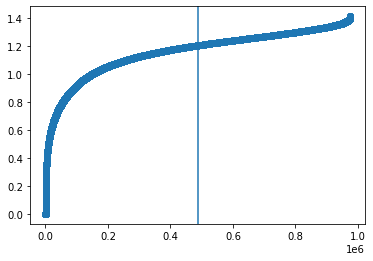

In [394]:
import matplotlib.pyplot as plt

plt.scatter(range(0,987**2), np.sort(ed.flatten()))
plt.axvline(987**2/2)
plt.show()

The euclidean distance among my 987 proteins range from 0 to 1.41, median is about 1.2. If I expect there to be 10-50 clusters within a dataset of 1,000 proteins, then I think my epsilon has got to be much smaller than this median. 

Try different epsilons now.

In [395]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)

for n in range_eps:
    clustering = DBSCAN(eps=n, min_samples=10).fit(X)
    cluster_labels = clustering.labels_
    
    if len(np.unique(cluster_labels))==1:
        print("eps = " + str(round(n, 2)) + ": Everything is a noise!")
    else:
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("eps = " + str(round(n, 2)) + ":", 
              str(round(silhouette_avg, 4)))

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

eps = 0.1: Everything is a noise!
eps = 0.2: -0.0065
eps = 0.3: -0.1116
eps = 0.4: 0.0274
eps = 0.5: 0.0745
eps = 0.6: 0.1006
eps = 0.7: 0.0621
eps = 0.8: 0.0858
eps = 0.9: 0.0836
eps = 1.0: 0.0923


Now let's try doing a manual grid search. We want to maximize the silouette score.

In [905]:
range_eps = np.linspace(start=0.1, stop=1.0, num=10)
range_min_samples = range(10, 200, 10)

from sklearn.metrics import davies_bouldin_score


def dbscan_gridsearch(X, range_eps, range_min_samples, metric='euclidean'):
    search_results = []
    for i in range_eps:
        for j in range_min_samples:
            clustering = DBSCAN(eps=i, 
                                min_samples=j,
                                metric=metric).fit(X)
            cluster_labels = clustering.labels_

            if len(np.unique(cluster_labels))==1:
                print("eps=" + str(round(i, 2)) + ", min_samples=" + str(j)  
                      + ": Everything is a noise!")
            else:
                sil_sc = silhouette_score(X, cluster_labels)
                db_sc = davies_bouldin_score(X, cluster_labels)
                print("eps=" + str(round(i, 2)) 
                      + " | min_samples=" + str(j) 
                      + " | Silhouette "+ str(round(sil_sc, 4))
                      + " | DB sc "+ str(round(db_sc, 4))
                      + " | noise " + str(sum(cluster_labels==-1))
                      + " | k " + str(len(np.unique(clustering.labels_)))
                      + " | max clus size " + str(np.unique(clustering.labels_, return_counts=True)[1][1:].max())
                     )
                search_results.append(((i, j), sil_sc, db_sc))

    return sorted(search_results, key=lambda x: x[1], reverse=True)



32

In [ ]:
search_results = dbscan_gridsearch(X, range_eps, range_min_samples)

In [408]:
search_results

[((0.6, 10), 0.10062334395122446),
 ((1.0, 180), 0.10019600298927343),
 ((1.0, 90), 0.10008703778391964),
 ((1.0, 170), 0.09996879475275447),
 ((1.0, 160), 0.09994635643362708),
 ((1.0, 190), 0.099843383104516),
 ((1.0, 120), 0.09975458237952906),
 ((1.0, 150), 0.09968969400558335),
 ((0.9, 30), 0.09966479716754044),
 ((1.0, 130), 0.09957527231470707),
 ((1.0, 110), 0.09945751277936156),
 ((1.0, 140), 0.09940835589336891),
 ((1.0, 100), 0.09867890593139018),
 ((1.0, 80), 0.09777008789765693),
 ((1.0, 70), 0.09736258993747669),
 ((1.0, 50), 0.0965156529388127),
 ((0.9, 60), 0.09642652017197094),
 ((0.9, 190), 0.09629273988643941),
 ((0.9, 180), 0.09625210701405415),
 ((0.9, 80), 0.09624053687037468),
 ((1.0, 40), 0.09623713712167237),
 ((1.0, 60), 0.09615374573902442),
 ((0.9, 50), 0.09614604537402098),
 ((0.9, 100), 0.09604364933028252),
 ((0.9, 70), 0.09601265971793706),
 ((0.9, 110), 0.0959877864207942),
 ((0.9, 120), 0.0959877864207942),
 ((0.9, 130), 0.09568807086067671),
 ((0.9, 9

Looks like the winner is: `eps=0.6, min_samples=10`

Now that we have a working grid search of sorts, let's try working on the entire dataset.

# Full dataset

In [633]:
# This is the list of file paths in gcs 
len(keys[1:])

21

In [766]:
missing_full=np.empty((0,1), dtype=str)
X_hold = [] 
protein_name_full=np.empty((0,1), dtype=str)
z=0

for key in keys[1:]:
    # I actually only need the file path once in the right storage.
    key = gcs.uri_to_bucket_and_key(key)[1]
    
    # parse the file 
    X, protein, missing_protein = protein_file_processor(key)
    
    # Put it into list 
    X_hold.append(X)
    protein_name_full = np.append(protein_name_full, protein)
    missing_full = np.append(missing_full, missing_protein)
    
    print(key, "missing", len(missing_protein))
    
# Stack all the X 
X_full = np.vstack(X_hold)

embeddings/DeepFold/embeddings_0.csv missing 14
embeddings/DeepFold/embeddings_1.csv missing 10
embeddings/DeepFold/embeddings_10.csv missing 8
embeddings/DeepFold/embeddings_11.csv missing 9
embeddings/DeepFold/embeddings_12.csv missing 6
embeddings/DeepFold/embeddings_13.csv missing 13
embeddings/DeepFold/embeddings_14.csv missing 16
embeddings/DeepFold/embeddings_15.csv missing 10
embeddings/DeepFold/embeddings_16.csv missing 16
embeddings/DeepFold/embeddings_17.csv missing 9
embeddings/DeepFold/embeddings_18.csv missing 5
embeddings/DeepFold/embeddings_19.csv missing 8
embeddings/DeepFold/embeddings_2.csv missing 11
embeddings/DeepFold/embeddings_20.csv missing 5
embeddings/DeepFold/embeddings_3.csv missing 8
embeddings/DeepFold/embeddings_4.csv missing 10
embeddings/DeepFold/embeddings_5.csv missing 11
embeddings/DeepFold/embeddings_6.csv missing 6
embeddings/DeepFold/embeddings_7.csv missing 13
embeddings/DeepFold/embeddings_8.csv missing 6
embeddings/DeepFold/embeddings_9.csv mi

In [767]:
len(X_hold)

21

In [855]:
X_full.shape

(20301, 398)

In [769]:
protein_name_full.shape

(20301,)

In [770]:
missing_full.shape

(203,)

In [857]:

# Create an empty list
filter_arr = []

# go through each element in arr
for element in X_full:
    # if the element is higher than 42, set the value to True, otherwise False:
#     print(element.shape, sum(element == 0))
    filter_arr.append(sum(element == 0))


(398,) 141
(398,) 194
(398,) 41
(398,) 159
(398,) 169
(398,) 135
(398,) 180
(398,) 330
(398,) 175
(398,) 179
(398,) 197
(398,) 234
(398,) 142
(398,) 167
(398,) 226
(398,) 199
(398,) 5
(398,) 69
(398,) 188
(398,) 172
(398,) 245
(398,) 109
(398,) 271
(398,) 92
(398,) 135
(398,) 152
(398,) 129
(398,) 85
(398,) 170
(398,) 176
(398,) 273
(398,) 191
(398,) 141
(398,) 131
(398,) 30
(398,) 179
(398,) 194
(398,) 196
(398,) 184
(398,) 139
(398,) 12
(398,) 164
(398,) 107
(398,) 140
(398,) 199
(398,) 142
(398,) 200
(398,) 192
(398,) 323
(398,) 167
(398,) 216
(398,) 136
(398,) 84
(398,) 84
(398,) 135
(398,) 337
(398,) 183
(398,) 204
(398,) 125
(398,) 196
(398,) 224
(398,) 226
(398,) 107
(398,) 142
(398,) 51
(398,) 173
(398,) 6
(398,) 168
(398,) 273
(398,) 170
(398,) 22
(398,) 289
(398,) 125
(398,) 247
(398,) 258
(398,) 51
(398,) 157
(398,) 259
(398,) 142
(398,) 141
(398,) 215
(398,) 199
(398,) 138
(398,) 273
(398,) 87
(398,) 224
(398,) 275
(398,) 16
(398,) 103
(398,) 269
(398,) 259
(398,) 119
(398,

(398,) 63
(398,) 99
(398,) 39
(398,) 55
(398,) 110
(398,) 127
(398,) 131
(398,) 63
(398,) 134
(398,) 220
(398,) 197
(398,) 134
(398,) 308
(398,) 224
(398,) 306
(398,) 141
(398,) 116
(398,) 280
(398,) 201
(398,) 175
(398,) 165
(398,) 194
(398,) 204
(398,) 183
(398,) 193
(398,) 132
(398,) 177
(398,) 125
(398,) 184
(398,) 169
(398,) 199
(398,) 157
(398,) 271
(398,) 67
(398,) 240
(398,) 120
(398,) 240
(398,) 258
(398,) 207
(398,) 5
(398,) 142
(398,) 171
(398,) 26
(398,) 180
(398,) 168
(398,) 148
(398,) 157
(398,) 97
(398,) 3
(398,) 208
(398,) 180
(398,) 53
(398,) 286
(398,) 263
(398,) 129
(398,) 79
(398,) 195
(398,) 199
(398,) 234
(398,) 130
(398,) 151
(398,) 92
(398,) 267
(398,) 198
(398,) 48
(398,) 236
(398,) 226
(398,) 139
(398,) 21
(398,) 121
(398,) 228
(398,) 246
(398,) 54
(398,) 197
(398,) 198
(398,) 144
(398,) 137
(398,) 137
(398,) 187
(398,) 50
(398,) 150
(398,) 177
(398,) 72
(398,) 79
(398,) 157
(398,) 214
(398,) 160
(398,) 243
(398,) 204
(398,) 172
(398,) 134
(398,) 275
(398,) 98

(398,) 181
(398,) 171
(398,) 157
(398,) 274
(398,) 157
(398,) 198
(398,) 171
(398,) 267
(398,) 127
(398,) 122
(398,) 247
(398,) 100
(398,) 263
(398,) 114
(398,) 98
(398,) 107
(398,) 157
(398,) 203
(398,) 241
(398,) 150
(398,) 120
(398,) 197
(398,) 158
(398,) 185
(398,) 151
(398,) 102
(398,) 142
(398,) 165
(398,) 77
(398,) 225
(398,) 210
(398,) 142
(398,) 151
(398,) 210
(398,) 116
(398,) 130
(398,) 117
(398,) 205
(398,) 214
(398,) 234
(398,) 188
(398,) 163
(398,) 108
(398,) 273
(398,) 92
(398,) 179
(398,) 191
(398,) 48
(398,) 255
(398,) 88
(398,) 159
(398,) 146
(398,) 105
(398,) 173
(398,) 138
(398,) 260
(398,) 176
(398,) 247
(398,) 219
(398,) 108
(398,) 212
(398,) 237
(398,) 54
(398,) 222
(398,) 156
(398,) 186
(398,) 194
(398,) 184
(398,) 314
(398,) 64
(398,) 233
(398,) 202
(398,) 144
(398,) 238
(398,) 53
(398,) 307
(398,) 184
(398,) 198
(398,) 47
(398,) 4
(398,) 279
(398,) 221
(398,) 279
(398,) 13
(398,) 220
(398,) 107
(398,) 90
(398,) 212
(398,) 76
(398,) 146
(398,) 166
(398,) 95
(39

(398,) 145
(398,) 99
(398,) 223
(398,) 235
(398,) 144
(398,) 159
(398,) 149
(398,) 122
(398,) 150
(398,) 192
(398,) 118
(398,) 136
(398,) 246
(398,) 133
(398,) 151
(398,) 145
(398,) 171
(398,) 192
(398,) 222
(398,) 183
(398,) 174
(398,) 203
(398,) 120
(398,) 143
(398,) 52
(398,) 80
(398,) 338
(398,) 236
(398,) 278
(398,) 143
(398,) 163
(398,) 263
(398,) 137
(398,) 121
(398,) 230
(398,) 216
(398,) 336
(398,) 160
(398,) 109
(398,) 237
(398,) 134
(398,) 160
(398,) 132
(398,) 247
(398,) 286
(398,) 224
(398,) 167
(398,) 116
(398,) 183
(398,) 114
(398,) 169
(398,) 109
(398,) 103
(398,) 255
(398,) 203
(398,) 160
(398,) 174
(398,) 77
(398,) 150
(398,) 200
(398,) 61
(398,) 126
(398,) 194
(398,) 196
(398,) 111
(398,) 56
(398,) 151
(398,) 227
(398,) 97
(398,) 140
(398,) 52
(398,) 89
(398,) 128
(398,) 211
(398,) 165
(398,) 179
(398,) 136
(398,) 156
(398,) 202
(398,) 161
(398,) 225
(398,) 283
(398,) 194
(398,) 257
(398,) 93
(398,) 139
(398,) 153
(398,) 60
(398,) 135
(398,) 197
(398,) 224
(398,) 32


(398,) 171
(398,) 160
(398,) 76
(398,) 159
(398,) 144
(398,) 145
(398,) 231
(398,) 178
(398,) 156
(398,) 172
(398,) 277
(398,) 154
(398,) 112
(398,) 178
(398,) 234
(398,) 254
(398,) 247
(398,) 208
(398,) 187
(398,) 287
(398,) 104
(398,) 147
(398,) 69
(398,) 159
(398,) 214
(398,) 86
(398,) 55
(398,) 275
(398,) 197
(398,) 169
(398,) 147
(398,) 126
(398,) 168
(398,) 136
(398,) 253
(398,) 188
(398,) 114
(398,) 232
(398,) 269
(398,) 250
(398,) 180
(398,) 182
(398,) 310
(398,) 233
(398,) 107
(398,) 85
(398,) 144
(398,) 207
(398,) 145
(398,) 165
(398,) 170
(398,) 237
(398,) 225
(398,) 170
(398,) 155
(398,) 176
(398,) 180
(398,) 68
(398,) 270
(398,) 122
(398,) 231
(398,) 326
(398,) 214
(398,) 271
(398,) 125
(398,) 146
(398,) 45
(398,) 177
(398,) 124
(398,) 37
(398,) 143
(398,) 134
(398,) 174
(398,) 157
(398,) 196
(398,) 36
(398,) 131
(398,) 219
(398,) 198
(398,) 195
(398,) 126
(398,) 155
(398,) 146
(398,) 171
(398,) 121
(398,) 196
(398,) 154
(398,) 121
(398,) 189
(398,) 134
(398,) 267
(398,) 1

(398,) 221
(398,) 107
(398,) 131
(398,) 184
(398,) 169
(398,) 91
(398,) 100
(398,) 207
(398,) 174
(398,) 126
(398,) 242
(398,) 204
(398,) 95
(398,) 217
(398,) 105
(398,) 234
(398,) 63
(398,) 105
(398,) 117
(398,) 147
(398,) 154
(398,) 164
(398,) 186
(398,) 230
(398,) 196
(398,) 324
(398,) 159
(398,) 160
(398,) 185
(398,) 112
(398,) 203
(398,) 195
(398,) 183
(398,) 265
(398,) 165
(398,) 158
(398,) 175
(398,) 218
(398,) 171
(398,) 159
(398,) 117
(398,) 121
(398,) 116
(398,) 83
(398,) 48
(398,) 164
(398,) 147
(398,) 75
(398,) 209
(398,) 134
(398,) 149
(398,) 315
(398,) 220
(398,) 206
(398,) 185
(398,) 124
(398,) 197
(398,) 118
(398,) 118
(398,) 114
(398,) 69
(398,) 104
(398,) 108
(398,) 123
(398,) 139
(398,) 267
(398,) 125
(398,) 173
(398,) 179
(398,) 115
(398,) 191
(398,) 159
(398,) 184
(398,) 203
(398,) 134
(398,) 227
(398,) 166
(398,) 307
(398,) 103
(398,) 122
(398,) 177
(398,) 113
(398,) 125
(398,) 153
(398,) 154
(398,) 194
(398,) 129
(398,) 138
(398,) 211
(398,) 143
(398,) 199
(398,)

(398,) 113
(398,) 142
(398,) 130
(398,) 160
(398,) 154
(398,) 152
(398,) 122
(398,) 121
(398,) 173
(398,) 152
(398,) 127
(398,) 74
(398,) 117
(398,) 178
(398,) 176
(398,) 195
(398,) 224
(398,) 295
(398,) 129
(398,) 196
(398,) 192
(398,) 149
(398,) 125
(398,) 297
(398,) 185
(398,) 128
(398,) 71
(398,) 157
(398,) 245
(398,) 272
(398,) 144
(398,) 56
(398,) 205
(398,) 322
(398,) 139
(398,) 149
(398,) 174
(398,) 257
(398,) 272
(398,) 267
(398,) 138
(398,) 97
(398,) 178
(398,) 255
(398,) 46
(398,) 148
(398,) 155
(398,) 120
(398,) 254
(398,) 176
(398,) 95
(398,) 89
(398,) 138
(398,) 139
(398,) 184
(398,) 158
(398,) 264
(398,) 127
(398,) 197
(398,) 154
(398,) 126
(398,) 171
(398,) 75
(398,) 200
(398,) 240
(398,) 67
(398,) 141
(398,) 206
(398,) 238
(398,) 88
(398,) 242
(398,) 207
(398,) 102
(398,) 209
(398,) 192
(398,) 111
(398,) 237
(398,) 180
(398,) 172
(398,) 147
(398,) 128
(398,) 188
(398,) 237
(398,) 148
(398,) 277
(398,) 153
(398,) 180
(398,) 143
(398,) 176
(398,) 177
(398,) 303
(398,) 13

(398,) 171
(398,) 222
(398,) 150
(398,) 107
(398,) 177
(398,) 92
(398,) 68
(398,) 216
(398,) 223
(398,) 228
(398,) 252
(398,) 80
(398,) 204
(398,) 183
(398,) 118
(398,) 105
(398,) 306
(398,) 64
(398,) 174
(398,) 162
(398,) 198
(398,) 162
(398,) 175
(398,) 83
(398,) 218
(398,) 65
(398,) 270
(398,) 265
(398,) 80
(398,) 245
(398,) 218
(398,) 182
(398,) 135
(398,) 87
(398,) 206
(398,) 156
(398,) 164
(398,) 53
(398,) 240
(398,) 129
(398,) 66
(398,) 88
(398,) 142
(398,) 56
(398,) 101
(398,) 154
(398,) 164
(398,) 109
(398,) 120
(398,) 273
(398,) 314
(398,) 267
(398,) 101
(398,) 180
(398,) 28
(398,) 275
(398,) 183
(398,) 133
(398,) 233
(398,) 219
(398,) 83
(398,) 171
(398,) 220
(398,) 190
(398,) 143
(398,) 154
(398,) 121
(398,) 123
(398,) 276
(398,) 177
(398,) 127
(398,) 215
(398,) 83
(398,) 148
(398,) 192
(398,) 257
(398,) 28
(398,) 289
(398,) 109
(398,) 259
(398,) 215
(398,) 140
(398,) 193
(398,) 174
(398,) 196
(398,) 155
(398,) 270
(398,) 83
(398,) 150
(398,) 289
(398,) 134
(398,) 139
(398,

(398,) 124
(398,) 123
(398,) 137
(398,) 311
(398,) 225
(398,) 164
(398,) 241
(398,) 106
(398,) 154
(398,) 310
(398,) 162
(398,) 120
(398,) 154
(398,) 196
(398,) 204
(398,) 203
(398,) 136
(398,) 96
(398,) 83
(398,) 102
(398,) 120
(398,) 255
(398,) 297
(398,) 181
(398,) 180
(398,) 231
(398,) 191
(398,) 63
(398,) 150
(398,) 122
(398,) 126
(398,) 210
(398,) 103
(398,) 177
(398,) 286
(398,) 181
(398,) 98
(398,) 222
(398,) 132
(398,) 118
(398,) 152
(398,) 167
(398,) 109
(398,) 248
(398,) 248
(398,) 217
(398,) 123
(398,) 180
(398,) 249
(398,) 167
(398,) 116
(398,) 189
(398,) 178
(398,) 168
(398,) 243
(398,) 92
(398,) 173
(398,) 127
(398,) 305
(398,) 275
(398,) 278
(398,) 210
(398,) 177
(398,) 177
(398,) 144
(398,) 150
(398,) 249
(398,) 182
(398,) 183
(398,) 124
(398,) 243
(398,) 182
(398,) 233
(398,) 149
(398,) 187
(398,) 80
(398,) 279
(398,) 59
(398,) 89
(398,) 291
(398,) 265
(398,) 162
(398,) 219
(398,) 259
(398,) 154
(398,) 179
(398,) 112
(398,) 156
(398,) 304
(398,) 143
(398,) 151
(398,) 

(398,) 127
(398,) 60
(398,) 229
(398,) 147
(398,) 307
(398,) 121
(398,) 115
(398,) 262
(398,) 205
(398,) 119
(398,) 214
(398,) 215
(398,) 187
(398,) 102
(398,) 267
(398,) 259
(398,) 126
(398,) 76
(398,) 88
(398,) 266
(398,) 276
(398,) 176
(398,) 146
(398,) 274
(398,) 194
(398,) 207
(398,) 286
(398,) 170
(398,) 241
(398,) 230
(398,) 150
(398,) 258
(398,) 181
(398,) 143
(398,) 71
(398,) 280
(398,) 65
(398,) 244
(398,) 98
(398,) 124
(398,) 307
(398,) 257
(398,) 125
(398,) 230
(398,) 182
(398,) 183
(398,) 74
(398,) 142
(398,) 109
(398,) 96
(398,) 201
(398,) 272
(398,) 80
(398,) 230
(398,) 212
(398,) 245
(398,) 286
(398,) 50
(398,) 290
(398,) 146
(398,) 161
(398,) 188
(398,) 174
(398,) 161
(398,) 202
(398,) 214
(398,) 197
(398,) 133
(398,) 184
(398,) 92
(398,) 188
(398,) 195
(398,) 217
(398,) 307
(398,) 185
(398,) 153
(398,) 118
(398,) 113
(398,) 85
(398,) 158
(398,) 135
(398,) 237
(398,) 117
(398,) 180
(398,) 160
(398,) 138
(398,) 73
(398,) 147
(398,) 43
(398,) 113
(398,) 230
(398,) 70
(39

(398,) 167
(398,) 216
(398,) 164
(398,) 120
(398,) 167
(398,) 127
(398,) 138
(398,) 124
(398,) 112
(398,) 134
(398,) 288
(398,) 233
(398,) 201
(398,) 115
(398,) 68
(398,) 197
(398,) 124
(398,) 127
(398,) 194
(398,) 209
(398,) 123
(398,) 232
(398,) 311
(398,) 210
(398,) 157
(398,) 134
(398,) 247
(398,) 143
(398,) 221
(398,) 273
(398,) 291
(398,) 206
(398,) 97
(398,) 311
(398,) 193
(398,) 185
(398,) 156
(398,) 110
(398,) 90
(398,) 119
(398,) 99
(398,) 284
(398,) 109
(398,) 175
(398,) 81
(398,) 97
(398,) 173
(398,) 140
(398,) 174
(398,) 144
(398,) 197
(398,) 174
(398,) 186
(398,) 83
(398,) 192
(398,) 264
(398,) 200
(398,) 129
(398,) 272
(398,) 146
(398,) 45
(398,) 89
(398,) 149
(398,) 214
(398,) 244
(398,) 238
(398,) 199
(398,) 178
(398,) 160
(398,) 203
(398,) 159
(398,) 188
(398,) 152
(398,) 311
(398,) 199
(398,) 135
(398,) 239
(398,) 296
(398,) 192
(398,) 217
(398,) 136
(398,) 131
(398,) 204
(398,) 151
(398,) 186
(398,) 128
(398,) 230
(398,) 160
(398,) 90
(398,) 238
(398,) 103
(398,) 18

(398,) 201
(398,) 126
(398,) 109
(398,) 106
(398,) 159
(398,) 97
(398,) 118
(398,) 104
(398,) 176
(398,) 38
(398,) 248
(398,) 32
(398,) 146
(398,) 221
(398,) 91
(398,) 146
(398,) 180
(398,) 126
(398,) 105
(398,) 155
(398,) 171
(398,) 259
(398,) 165
(398,) 160
(398,) 297
(398,) 161
(398,) 269
(398,) 187
(398,) 165
(398,) 167
(398,) 158
(398,) 219
(398,) 133
(398,) 98
(398,) 212
(398,) 147
(398,) 148
(398,) 209
(398,) 265
(398,) 89
(398,) 114
(398,) 191
(398,) 68
(398,) 142
(398,) 160
(398,) 328
(398,) 135
(398,) 100
(398,) 117
(398,) 153
(398,) 130
(398,) 87
(398,) 112
(398,) 154
(398,) 149
(398,) 77
(398,) 185
(398,) 181
(398,) 169
(398,) 121
(398,) 190
(398,) 315
(398,) 204
(398,) 216
(398,) 145
(398,) 179
(398,) 266
(398,) 143
(398,) 57
(398,) 212
(398,) 157
(398,) 219
(398,) 158
(398,) 290
(398,) 94
(398,) 98
(398,) 229
(398,) 160
(398,) 143
(398,) 161
(398,) 138
(398,) 137
(398,) 54
(398,) 192
(398,) 213
(398,) 238
(398,) 272
(398,) 242
(398,) 104
(398,) 306
(398,) 198
(398,) 91
(3

(398,) 243
(398,) 198
(398,) 192
(398,) 146
(398,) 188
(398,) 149
(398,) 119
(398,) 274
(398,) 166
(398,) 159
(398,) 87
(398,) 28
(398,) 98
(398,) 117
(398,) 265
(398,) 258
(398,) 203
(398,) 67
(398,) 156
(398,) 113
(398,) 116
(398,) 78
(398,) 210
(398,) 172
(398,) 145
(398,) 237
(398,) 170
(398,) 123
(398,) 303
(398,) 183
(398,) 220
(398,) 159
(398,) 162
(398,) 195
(398,) 162
(398,) 152
(398,) 195
(398,) 133
(398,) 190
(398,) 120
(398,) 303
(398,) 187
(398,) 171
(398,) 160
(398,) 129
(398,) 129
(398,) 86
(398,) 127
(398,) 248
(398,) 170
(398,) 30
(398,) 148
(398,) 129
(398,) 153
(398,) 168
(398,) 145
(398,) 114
(398,) 78
(398,) 119
(398,) 178
(398,) 204
(398,) 305
(398,) 158
(398,) 150
(398,) 137
(398,) 87
(398,) 200
(398,) 91
(398,) 89
(398,) 257
(398,) 151
(398,) 72
(398,) 114
(398,) 184
(398,) 270
(398,) 244
(398,) 264
(398,) 169
(398,) 134
(398,) 266
(398,) 175
(398,) 260
(398,) 117
(398,) 144
(398,) 171
(398,) 252
(398,) 230
(398,) 129
(398,) 173
(398,) 120
(398,) 76
(398,) 105
(

(398,) 247
(398,) 249
(398,) 109
(398,) 280
(398,) 143
(398,) 186
(398,) 202
(398,) 224
(398,) 195
(398,) 142
(398,) 122
(398,) 74
(398,) 127
(398,) 136
(398,) 225
(398,) 197
(398,) 88
(398,) 141
(398,) 133
(398,) 276
(398,) 100
(398,) 285
(398,) 165
(398,) 176
(398,) 138
(398,) 290
(398,) 222
(398,) 104
(398,) 194
(398,) 110
(398,) 127
(398,) 181
(398,) 212
(398,) 103
(398,) 289
(398,) 296
(398,) 83
(398,) 57
(398,) 116
(398,) 191
(398,) 134
(398,) 176
(398,) 81
(398,) 195
(398,) 188
(398,) 187
(398,) 188
(398,) 25
(398,) 147
(398,) 140
(398,) 139
(398,) 152
(398,) 112
(398,) 192
(398,) 285
(398,) 109
(398,) 158
(398,) 298
(398,) 120
(398,) 179
(398,) 279
(398,) 165
(398,) 214
(398,) 239
(398,) 156
(398,) 110
(398,) 127
(398,) 240
(398,) 200
(398,) 101
(398,) 163
(398,) 239
(398,) 43
(398,) 106
(398,) 283
(398,) 114
(398,) 188
(398,) 176
(398,) 219
(398,) 144
(398,) 290
(398,) 138
(398,) 239
(398,) 142
(398,) 217
(398,) 203
(398,) 277
(398,) 276
(398,) 242
(398,) 192
(398,) 120
(398,)

(398,) 87
(398,) 59
(398,) 121
(398,) 195
(398,) 246
(398,) 155
(398,) 122
(398,) 155
(398,) 193
(398,) 142
(398,) 153
(398,) 157
(398,) 162
(398,) 142
(398,) 131
(398,) 175
(398,) 50
(398,) 247
(398,) 97
(398,) 150
(398,) 63
(398,) 155
(398,) 199
(398,) 157
(398,) 108
(398,) 250
(398,) 168
(398,) 62
(398,) 205
(398,) 245
(398,) 177
(398,) 215
(398,) 71
(398,) 164
(398,) 115
(398,) 234
(398,) 173
(398,) 137
(398,) 133
(398,) 204
(398,) 284
(398,) 109
(398,) 102
(398,) 119
(398,) 260
(398,) 208
(398,) 275
(398,) 260
(398,) 140
(398,) 137
(398,) 88
(398,) 260
(398,) 208
(398,) 208
(398,) 195
(398,) 202
(398,) 164
(398,) 184
(398,) 128
(398,) 100
(398,) 102
(398,) 161
(398,) 158
(398,) 154
(398,) 188
(398,) 177
(398,) 149
(398,) 98
(398,) 104
(398,) 201
(398,) 100
(398,) 143
(398,) 164
(398,) 67
(398,) 150
(398,) 223
(398,) 241
(398,) 113
(398,) 72
(398,) 216
(398,) 186
(398,) 89
(398,) 146
(398,) 78
(398,) 127
(398,) 256
(398,) 161
(398,) 164
(398,) 229
(398,) 177
(398,) 207
(398,) 179
(

(398,) 64
(398,) 248
(398,) 145
(398,) 129
(398,) 32
(398,) 206
(398,) 204
(398,) 64
(398,) 71
(398,) 308
(398,) 137
(398,) 153
(398,) 115
(398,) 169
(398,) 264
(398,) 114
(398,) 138
(398,) 134
(398,) 87
(398,) 29
(398,) 183
(398,) 174
(398,) 7
(398,) 166
(398,) 136
(398,) 71
(398,) 166
(398,) 249
(398,) 220
(398,) 177
(398,) 270
(398,) 135
(398,) 75
(398,) 112
(398,) 115
(398,) 151
(398,) 270
(398,) 194
(398,) 191
(398,) 129
(398,) 178
(398,) 266
(398,) 172
(398,) 147
(398,) 83
(398,) 176
(398,) 192
(398,) 227
(398,) 154
(398,) 81
(398,) 120
(398,) 194
(398,) 173
(398,) 241
(398,) 161
(398,) 279
(398,) 272
(398,) 169
(398,) 191
(398,) 275
(398,) 296
(398,) 182
(398,) 34
(398,) 155
(398,) 158
(398,) 194
(398,) 123
(398,) 141
(398,) 82
(398,) 158
(398,) 203
(398,) 93
(398,) 161
(398,) 158
(398,) 154
(398,) 89
(398,) 249
(398,) 172
(398,) 28
(398,) 79
(398,) 31
(398,) 172
(398,) 310
(398,) 116
(398,) 178
(398,) 114
(398,) 127
(398,) 139
(398,) 175
(398,) 27
(398,) 219
(398,) 169
(398,) 2

(398,) 222
(398,) 188
(398,) 139
(398,) 178
(398,) 142
(398,) 145
(398,) 191
(398,) 167
(398,) 256
(398,) 208
(398,) 264
(398,) 266
(398,) 92
(398,) 136
(398,) 312
(398,) 198
(398,) 167
(398,) 221
(398,) 250
(398,) 187
(398,) 157
(398,) 170
(398,) 225
(398,) 48
(398,) 231
(398,) 298
(398,) 138
(398,) 145
(398,) 160
(398,) 170
(398,) 124
(398,) 116
(398,) 145
(398,) 239
(398,) 164
(398,) 240
(398,) 190
(398,) 120
(398,) 155
(398,) 103
(398,) 277
(398,) 178
(398,) 146
(398,) 299
(398,) 271
(398,) 170
(398,) 48
(398,) 81
(398,) 227
(398,) 282
(398,) 239
(398,) 82
(398,) 88
(398,) 51
(398,) 178
(398,) 102
(398,) 140
(398,) 30
(398,) 298
(398,) 110
(398,) 180
(398,) 260
(398,) 85
(398,) 179
(398,) 177
(398,) 118
(398,) 199
(398,) 167
(398,) 181
(398,) 239
(398,) 300
(398,) 158
(398,) 116
(398,) 226
(398,) 117
(398,) 277
(398,) 171
(398,) 111
(398,) 228
(398,) 168
(398,) 133
(398,) 233
(398,) 60
(398,) 195
(398,) 206
(398,) 283
(398,) 266
(398,) 205
(398,) 234
(398,) 153
(398,) 181
(398,) 27

(398,) 140
(398,) 181
(398,) 246
(398,) 135
(398,) 135
(398,) 193
(398,) 209
(398,) 227
(398,) 311
(398,) 249
(398,) 184
(398,) 94
(398,) 205
(398,) 257
(398,) 112
(398,) 94
(398,) 190
(398,) 107
(398,) 185
(398,) 213
(398,) 309
(398,) 191
(398,) 305
(398,) 165
(398,) 158
(398,) 219
(398,) 208
(398,) 209
(398,) 115
(398,) 186
(398,) 139
(398,) 162
(398,) 152
(398,) 116
(398,) 263
(398,) 182
(398,) 196
(398,) 214
(398,) 92
(398,) 117
(398,) 195
(398,) 95
(398,) 134
(398,) 308
(398,) 216
(398,) 240
(398,) 172
(398,) 148
(398,) 165
(398,) 170
(398,) 179
(398,) 185
(398,) 99
(398,) 196
(398,) 251
(398,) 91
(398,) 142
(398,) 168
(398,) 218
(398,) 185
(398,) 182
(398,) 84
(398,) 274
(398,) 247
(398,) 153
(398,) 100
(398,) 115
(398,) 110
(398,) 163
(398,) 126
(398,) 234
(398,) 321
(398,) 196
(398,) 322
(398,) 212
(398,) 193
(398,) 188
(398,) 217
(398,) 276
(398,) 261
(398,) 127
(398,) 155
(398,) 256
(398,) 118
(398,) 90
(398,) 169
(398,) 126
(398,) 105
(398,) 188
(398,) 238
(398,) 191
(398,) 

(398,) 182
(398,) 130
(398,) 125
(398,) 317
(398,) 131
(398,) 160
(398,) 75
(398,) 131
(398,) 252
(398,) 192
(398,) 170
(398,) 130
(398,) 262
(398,) 329
(398,) 164
(398,) 51
(398,) 259
(398,) 330
(398,) 217
(398,) 51
(398,) 186
(398,) 77
(398,) 149
(398,) 241
(398,) 73
(398,) 188
(398,) 180
(398,) 61
(398,) 81
(398,) 61
(398,) 120
(398,) 171
(398,) 63
(398,) 123
(398,) 85
(398,) 181
(398,) 120
(398,) 137
(398,) 174
(398,) 253
(398,) 267
(398,) 61
(398,) 274
(398,) 45
(398,) 149
(398,) 107
(398,) 247
(398,) 128
(398,) 158
(398,) 83
(398,) 265
(398,) 188
(398,) 143
(398,) 101
(398,) 201
(398,) 201
(398,) 172
(398,) 137
(398,) 249
(398,) 126
(398,) 110
(398,) 196
(398,) 126
(398,) 225
(398,) 184
(398,) 56
(398,) 208
(398,) 236
(398,) 105
(398,) 268
(398,) 125
(398,) 92
(398,) 141
(398,) 132
(398,) 241
(398,) 298
(398,) 199
(398,) 137
(398,) 194
(398,) 108
(398,) 198
(398,) 113
(398,) 197
(398,) 108
(398,) 180
(398,) 168
(398,) 47
(398,) 136
(398,) 119
(398,) 149
(398,) 142
(398,) 82
(398,

(398,) 156
(398,) 229
(398,) 202
(398,) 186
(398,) 148
(398,) 177
(398,) 232
(398,) 133
(398,) 242
(398,) 97
(398,) 79
(398,) 316
(398,) 145
(398,) 149
(398,) 171
(398,) 153
(398,) 169
(398,) 188
(398,) 221
(398,) 99
(398,) 166
(398,) 158
(398,) 129
(398,) 191
(398,) 187
(398,) 188
(398,) 172
(398,) 266
(398,) 219
(398,) 127
(398,) 271
(398,) 170
(398,) 188
(398,) 135
(398,) 166
(398,) 171
(398,) 183
(398,) 128
(398,) 176
(398,) 186
(398,) 143
(398,) 74
(398,) 125
(398,) 257
(398,) 64
(398,) 130
(398,) 91
(398,) 196
(398,) 88
(398,) 191
(398,) 197
(398,) 186
(398,) 150
(398,) 177
(398,) 133
(398,) 238
(398,) 231
(398,) 193
(398,) 249
(398,) 294
(398,) 87
(398,) 197
(398,) 139
(398,) 103
(398,) 310
(398,) 105
(398,) 75
(398,) 179
(398,) 86
(398,) 132
(398,) 38
(398,) 130
(398,) 191
(398,) 267
(398,) 269
(398,) 275
(398,) 312
(398,) 321
(398,) 322
(398,) 192
(398,) 222
(398,) 231
(398,) 130
(398,) 199
(398,) 53
(398,) 176
(398,) 245
(398,) 129
(398,) 156
(398,) 217
(398,) 176
(398,) 201


(398,) 105
(398,) 98
(398,) 126
(398,) 76
(398,) 173
(398,) 244
(398,) 179
(398,) 124
(398,) 133
(398,) 82
(398,) 189
(398,) 128
(398,) 257
(398,) 196
(398,) 56
(398,) 84
(398,) 206
(398,) 86
(398,) 247
(398,) 263
(398,) 187
(398,) 229
(398,) 120
(398,) 139
(398,) 183
(398,) 137
(398,) 216
(398,) 146
(398,) 304
(398,) 178
(398,) 104
(398,) 132
(398,) 104
(398,) 134
(398,) 107
(398,) 174
(398,) 157
(398,) 131
(398,) 173
(398,) 118
(398,) 154
(398,) 102
(398,) 147
(398,) 162
(398,) 192
(398,) 65
(398,) 95
(398,) 127
(398,) 236
(398,) 69
(398,) 245
(398,) 159
(398,) 83
(398,) 264
(398,) 185
(398,) 102
(398,) 123
(398,) 215
(398,) 141
(398,) 174
(398,) 261
(398,) 127
(398,) 182
(398,) 97
(398,) 177
(398,) 209
(398,) 151
(398,) 261
(398,) 180
(398,) 119
(398,) 232
(398,) 303
(398,) 150
(398,) 118
(398,) 212
(398,) 94
(398,) 166
(398,) 119
(398,) 126
(398,) 305
(398,) 117
(398,) 151
(398,) 136
(398,) 71
(398,) 82
(398,) 204
(398,) 158
(398,) 109
(398,) 179
(398,) 272
(398,) 195
(398,) 166
(3

(398,) 158
(398,) 121
(398,) 123
(398,) 261
(398,) 164
(398,) 121
(398,) 206
(398,) 138
(398,) 186
(398,) 164
(398,) 298
(398,) 134
(398,) 254
(398,) 139
(398,) 96
(398,) 90
(398,) 162
(398,) 170
(398,) 121
(398,) 63
(398,) 141
(398,) 122
(398,) 120
(398,) 214
(398,) 139
(398,) 154
(398,) 161
(398,) 157
(398,) 162
(398,) 270
(398,) 201
(398,) 238
(398,) 255
(398,) 43
(398,) 183
(398,) 48
(398,) 78
(398,) 182
(398,) 173
(398,) 302
(398,) 176
(398,) 157
(398,) 89
(398,) 186
(398,) 52
(398,) 142
(398,) 285
(398,) 269
(398,) 114
(398,) 164
(398,) 71
(398,) 225
(398,) 136
(398,) 182
(398,) 189
(398,) 158
(398,) 240
(398,) 239
(398,) 247
(398,) 163
(398,) 104
(398,) 182
(398,) 66
(398,) 124
(398,) 66
(398,) 124
(398,) 272
(398,) 226
(398,) 169
(398,) 145
(398,) 226
(398,) 218
(398,) 305
(398,) 221
(398,) 244
(398,) 226
(398,) 289
(398,) 185
(398,) 173
(398,) 111
(398,) 176
(398,) 190
(398,) 197
(398,) 132
(398,) 231
(398,) 62
(398,) 127
(398,) 251
(398,) 112
(398,) 113
(398,) 125
(398,) 280


(398,) 182
(398,) 156
(398,) 262
(398,) 185
(398,) 178
(398,) 76
(398,) 248
(398,) 176
(398,) 254
(398,) 72
(398,) 54
(398,) 251
(398,) 258
(398,) 196
(398,) 51
(398,) 213
(398,) 54
(398,) 232
(398,) 193
(398,) 247
(398,) 154
(398,) 266
(398,) 192
(398,) 101
(398,) 251
(398,) 244
(398,) 178
(398,) 112
(398,) 197
(398,) 243
(398,) 184
(398,) 285
(398,) 233
(398,) 152
(398,) 135
(398,) 115
(398,) 200
(398,) 98
(398,) 306
(398,) 158
(398,) 193
(398,) 251
(398,) 108
(398,) 95
(398,) 136
(398,) 126
(398,) 156
(398,) 141
(398,) 203
(398,) 170
(398,) 172
(398,) 44
(398,) 113
(398,) 91
(398,) 190
(398,) 268
(398,) 166
(398,) 92
(398,) 166
(398,) 174
(398,) 136
(398,) 219
(398,) 102
(398,) 161
(398,) 98
(398,) 61
(398,) 261
(398,) 244
(398,) 259
(398,) 331
(398,) 183
(398,) 184
(398,) 261
(398,) 201
(398,) 273
(398,) 306
(398,) 169
(398,) 209
(398,) 169
(398,) 263
(398,) 97
(398,) 273
(398,) 158
(398,) 187
(398,) 233
(398,) 148
(398,) 74
(398,) 187
(398,) 279
(398,) 171
(398,) 235
(398,) 238
(3

(398,) 236
(398,) 81
(398,) 271
(398,) 227
(398,) 195
(398,) 301
(398,) 209
(398,) 47
(398,) 134
(398,) 127
(398,) 133
(398,) 264
(398,) 127
(398,) 98
(398,) 211
(398,) 216
(398,) 185
(398,) 167
(398,) 124
(398,) 218
(398,) 282
(398,) 249
(398,) 180
(398,) 70
(398,) 236
(398,) 224
(398,) 227
(398,) 115
(398,) 251
(398,) 133
(398,) 223
(398,) 166
(398,) 135
(398,) 197
(398,) 228
(398,) 82
(398,) 201
(398,) 95
(398,) 223
(398,) 293
(398,) 199
(398,) 157
(398,) 99
(398,) 193
(398,) 231
(398,) 200
(398,) 253
(398,) 69
(398,) 86
(398,) 90
(398,) 250
(398,) 170
(398,) 70
(398,) 231
(398,) 99
(398,) 69
(398,) 153
(398,) 162
(398,) 157
(398,) 166
(398,) 86
(398,) 179
(398,) 258
(398,) 70
(398,) 259
(398,) 116
(398,) 60
(398,) 115
(398,) 128
(398,) 71
(398,) 229
(398,) 150
(398,) 54
(398,) 154
(398,) 191
(398,) 193
(398,) 103
(398,) 113
(398,) 148
(398,) 173
(398,) 182
(398,) 80
(398,) 209
(398,) 302
(398,) 115
(398,) 166
(398,) 171
(398,) 140
(398,) 181
(398,) 258
(398,) 249
(398,) 274
(398,) 

(398,) 251
(398,) 113
(398,) 277
(398,) 159
(398,) 115
(398,) 139
(398,) 105
(398,) 179
(398,) 210
(398,) 198
(398,) 138
(398,) 126
(398,) 168
(398,) 151
(398,) 213
(398,) 137
(398,) 198
(398,) 266
(398,) 145
(398,) 134
(398,) 162
(398,) 233
(398,) 142
(398,) 94
(398,) 245
(398,) 144
(398,) 119
(398,) 294
(398,) 253
(398,) 155
(398,) 196
(398,) 288
(398,) 162
(398,) 154
(398,) 68
(398,) 241
(398,) 230
(398,) 239
(398,) 254
(398,) 157
(398,) 125
(398,) 175
(398,) 258
(398,) 154
(398,) 151
(398,) 186
(398,) 151
(398,) 76
(398,) 175
(398,) 257
(398,) 143
(398,) 105
(398,) 182
(398,) 237
(398,) 84
(398,) 177
(398,) 279
(398,) 167
(398,) 192
(398,) 190
(398,) 96
(398,) 236
(398,) 83
(398,) 182
(398,) 195
(398,) 269
(398,) 120
(398,) 238
(398,) 142
(398,) 144
(398,) 149
(398,) 110
(398,) 109
(398,) 189
(398,) 84
(398,) 240
(398,) 122
(398,) 257
(398,) 167
(398,) 191
(398,) 126
(398,) 172
(398,) 199
(398,) 175
(398,) 114
(398,) 190
(398,) 138
(398,) 166
(398,) 142
(398,) 292
(398,) 77
(398,) 

In [910]:

# Create an empty list
filter_arr = []

# go through each element in arr
for element in X_full:
    # if the element is higher than 42, set the value to True, otherwise False:
#     print(element.shape, sum(element == 0))
    filter_arr.append(sum(element < 0))


In [911]:
[x for x in filter_arr if x > 0 ]

[]

In [858]:
np.mean(filter_arr)

169.71296980444313

## Cluster full data

In [715]:
ed = euclidean_distances(X_full, X_full)
ed.shape

(20301, 20301)

In [716]:
min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)

0.0 1.413966410491882 1.1221421372670195


In [717]:
ed_flatten = ed.flatten()

In [718]:
ed_flatten.shape

(412130601,)

In [719]:
sample_ed = np.random.choice(ed_flatten, 10000)

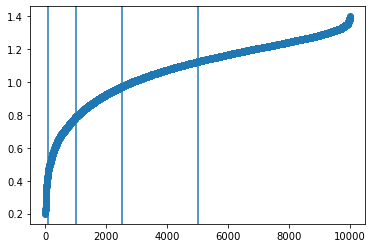

In [720]:
plt.scatter(range(len(sample_ed)), np.sort(sample_ed))
plt.axvline(len(sample_ed)/2)
plt.axvline(len(sample_ed)/4)
plt.axvline(len(sample_ed)/10)
plt.axvline(len(sample_ed)/100)
plt.show()

In [722]:
range_eps = np.linspace(start=0.01, stop=0.4, num=5)
range_min_samples = [10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01 | min_samples=10 | Silhouette 0.0302 | DB sc0.9076
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.11 | min_samples=10 | Silhouette -0.2743 | DB sc1.0956
eps=0.11 | min_samples=20 | Silhouette -0.1712 | DB sc1.2291
eps=0.11 | min_samples=50 | Silhouette -0.094 | DB sc1.2608
eps=0.2 | min_samples=10 | Silhouette -0.2358 | DB sc1.1521
eps=0.2 | min_samples=20 | Silhouette -0.1864 | DB sc1.1703
eps=0.2 | min_samples=50 | Silhouette -0.1552 | DB sc1.2942
eps=0.3 | min_samples=10 | Silhouette -0.201 | DB sc1.3
eps=0.3 | min_samples=20 | Silhouette -0.1209 | DB sc1.3759
eps=0.3 | min_samples=50 | Silhouette -0.0672 | DB sc1.7609
eps=0.4 | min_samples=10 | Silhouette -0.1602 | DB sc1.4666
eps=0.4 | min_samples=20 | Silhouette -0.0135 | DB sc1.729
eps=0.4 | min_samples=50 | Silhouette 0.0251 | DB sc1.7484


In [723]:
range_eps = np.linspace(start=0.01, stop=0.1, num=3)
range_min_samples = [5, 10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01 | min_samples=5 | Silhouette 0.0304 | DB sc0.908
eps=0.01 | min_samples=10 | Silhouette 0.0302 | DB sc0.9076
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.06 | min_samples=5 | Silhouette -0.3173 | DB sc1.0198
eps=0.06 | min_samples=10 | Silhouette -0.2172 | DB sc0.9668
eps=0.06, min_samples=20: Everything is a noise!
eps=0.06, min_samples=50: Everything is a noise!
eps=0.1 | min_samples=5 | Silhouette -0.309 | DB sc1.0028
eps=0.1 | min_samples=10 | Silhouette -0.2753 | DB sc1.083
eps=0.1 | min_samples=20 | Silhouette -0.176 | DB sc1.2115
eps=0.1 | min_samples=50 | Silhouette -0.0981 | DB sc1.2471


In [724]:
# At first, the grid search tried to tell me eps=0.6 was good
clustering = DBSCAN(eps=0.6, min_samples=25).fit(X_full)

In [725]:
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  6142]
 [    0 13724]
 [    1   133]
 [    2   253]
 [    3    49]]


Oh no, the epsilon is too generous. So I ran grid search again but limited eps to 0.4. Anything below that would give me only negative Silhouette scores.

In [728]:
clustering = DBSCAN(eps=0.4, min_samples=20).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1 11906]
 [    0  6992]
 [    1   268]
 [    2   288]
 [    3   295]
 [    4   215]
 [    5    72]
 [    6    38]
 [    7    79]
 [    8    20]
 [    9    86]
 [   10    21]
 [   11    21]]


The cluster sizes look OK now, but almost half the proteins are considered noise, and 40% are in cluster index 0.

In [729]:
clustering = DBSCAN(eps=0.5, min_samples=10).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[   -1  7832]
 [    0 11527]
 [    1    12]
 [    2    19]
 [    3    20]
 [    4    12]
 [    5    15]
 [    6   245]
 [    7    19]
 [    8    11]
 [    9    20]
 [   10    11]
 [   11    11]
 [   12   120]
 [   13    12]
 [   14    21]
 [   15    15]
 [   16    10]
 [   17    41]
 [   18     9]
 [   19    10]
 [   20    18]
 [   21    22]
 [   22    18]
 [   23    28]
 [   24    13]
 [   25    21]
 [   26    15]
 [   27    16]
 [   28    18]
 [   29    13]
 [   30    15]
 [   31    11]
 [   32    11]
 [   33    12]
 [   34    16]
 [   35    19]
 [   36    14]
 [   37    12]
 [   38    10]
 [   39     7]]


Even 0.5 is too generous for an epsilon. See how big cluster 0 is!

In [730]:
# So I guess eps=0.4 it is. 
clustering = DBSCAN(eps=0.40, min_samples=5).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[  -1 9999]
 [   0 8790]
 [   1   12]
 [   2   15]
 [   3   19]
 [   4    5]
 [   5    6]
 [   6    8]
 [   7   41]
 [   8   15]
 [   9    9]
 [  10  234]
 [  11    5]
 [  12   15]
 [  13   39]
 [  14   10]
 [  15    4]
 [  16   16]
 [  17   10]
 [  18   11]
 [  19    6]
 [  20    5]
 [  21   98]
 [  22    7]
 [  23    9]
 [  24   12]
 [  25   20]
 [  26    9]
 [  27    5]
 [  28    8]
 [  29    5]
 [  30   71]
 [  31    7]
 [  32    6]
 [  33    5]
 [  34    8]
 [  35    9]
 [  36    7]
 [  37   10]
 [  38    9]
 [  39    6]
 [  40   16]
 [  41   22]
 [  42    5]
 [  43   18]
 [  44    6]
 [  45    5]
 [  46    5]
 [  47   35]
 [  48   11]
 [  49   17]
 [  50   11]
 [  51    7]
 [  52    7]
 [  53    6]
 [  54    6]
 [  55    6]
 [  56    5]
 [  57    6]
 [  58    9]
 [  59    6]
 [  60    7]
 [  61   10]
 [  62    7]
 [  63    6]
 [  64    6]
 [  65   13]
 [  66   13]
 [  67    5]
 [  68    7]
 [  69    7]
 [  70    5]
 [  71    8]
 [  72    5]
 [  73    5]
 [  74    6]
 [  75    9]

Still almost half of the points are considered noise. Can I reduce it if I lower the min_samples param?

In [731]:
clustering = DBSCAN(eps=0.40, min_samples=2).fit(X_full)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

[[  -1 7450]
 [   0 9026]
 [   1    2]
 ...
 [1091    2]
 [1092    2]
 [1093    2]]


So the noise went down somewhat, but still substantial. And cluster 0 is still too big.



In [586]:
range_eps = np.linspace(start=0.01, stop=0.4, num=5)
range_min_samples = [6, 10, 20, 50]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples)

eps=0.01, min_samples=6: 0.8989
eps=0.01, min_samples=10: 0.8984
eps=0.01, min_samples=20: Everything is a noise!
eps=0.01, min_samples=50: Everything is a noise!
eps=0.05, min_samples=6: 0.9951
eps=0.05, min_samples=10: 0.9808
eps=0.05, min_samples=20: 0.9988
eps=0.05, min_samples=50: Everything is a noise!
eps=0.1, min_samples=6: 1.0155
eps=0.1, min_samples=10: 1.0012
eps=0.1, min_samples=20: 1.2122
eps=0.1, min_samples=50: 1.1999
eps=0.14, min_samples=6: 1.0308
eps=0.14, min_samples=10: 1.0068
eps=0.14, min_samples=20: 1.1046
eps=0.14, min_samples=50: 1.1522
eps=0.18, min_samples=6: 1.0937
eps=0.18, min_samples=10: 1.0704
eps=0.18, min_samples=20: 1.0905
eps=0.18, min_samples=50: 1.2035
eps=0.23, min_samples=6: 1.1513
eps=0.23, min_samples=10: 1.1714
eps=0.23, min_samples=20: 1.2384
eps=0.23, min_samples=50: 1.2159
eps=0.27, min_samples=6: 1.1877
eps=0.27, min_samples=10: 1.187
eps=0.27, min_samples=20: 1.2673
eps=0.27, min_samples=50: 1.663
eps=0.31, min_samples=6: 1.2364
eps=0.31,

# Refinement

To try
Next things to try:
1. Reduce dimensionality of DeepFold embeddings to 100
2. Incorporate BLAST and see what it says about clusters
3. When RMSD & TM score are ready then incorporate them to see what they say about clusters
4. Save model & results (some form of pipeline) 

In [732]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=100)
print("X_full orig shape", X_full.shape)
X_transformed = embedding.fit_transform(X_full)
print("X_transformed new shape", X_transformed.shape)

X_full orig shape (20301, 398)
X_transformed new shape (20301, 100)


In [733]:
print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

clustering = DBSCAN(eps=0.40, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.239694043783252
silhouette score -0.36896264426309094
[[   -1 16805]
 [    0    82]
 [    1   313]
 [    2    18]
 [    3    12]
 [    4   651]
 [    5     6]
 [    6    51]
 [    7   791]
 [    8    23]
 [    9    14]
 [   10    20]
 [   11     6]
 [   12     6]
 [   13    30]
 [   14    13]
 [   15     5]
 [   16     7]
 [   17     5]
 [   18     7]
 [   19    34]
 [   20    11]
 [   21     9]
 [   22    51]
 [   23    12]
 [   24    41]
 [   25    66]
 [   26    28]
 [   27    11]
 [   28     6]
 [   29     6]
 [   30    10]
 [   31    11]
 [   32    12]
 [   33     9]
 [   34    21]
 [   35     8]
 [   36     5]
 [   37     9]
 [   38    16]
 [   39    12]
 [   40    24]
 [   41    45]
 [   42     6]
 [   43     8]
 [   44     6]
 [   45     8]
 [   46    13]
 [   47    11]
 [   48    27]
 [   49     6]
 [   50     5]
 [   51    12]
 [   52    26]
 [   53    11]
 [   54     5]
 [   55     9]
 [   56    11]
 [   57     9]
 [   58    14]
 [   59     7]
 [   60    11]
 [   

In [734]:
import bz2
import pickle

filename='DeepFold_100'
# outfile = open(filename,'wb')
outfile = bz2.BZ2File(filename, 'w')
pickle.dump(X_transformed,outfile)
outfile.close()

In [735]:
range_eps = np.linspace(start=0.01, stop=0.4, num=3)
range_min_samples = [6, 10, 20, 50]

search_results = dbscan_gridsearch(X_transformed, range_eps, range_min_samples)

eps=0.01 | min_samples=6 | Silhouette -0.0314 | DB sc0.959
eps=0.01 | min_samples=10 | Silhouette -0.0303 | DB sc1.0896
eps=0.01 | min_samples=20 | Silhouette -0.0303 | DB sc1.0896
eps=0.01, min_samples=50: Everything is a noise!
eps=0.2 | min_samples=6 | Silhouette -0.3837 | DB sc1.0347
eps=0.2 | min_samples=10 | Silhouette -0.3619 | DB sc1.1401
eps=0.2 | min_samples=20 | Silhouette -0.274 | DB sc1.5345
eps=0.2, min_samples=50: Everything is a noise!
eps=0.4 | min_samples=6 | Silhouette -0.3386 | DB sc1.1288
eps=0.4 | min_samples=10 | Silhouette -0.3281 | DB sc1.1633
eps=0.4 | min_samples=20 | Silhouette -0.2883 | DB sc1.7143
eps=0.4 | min_samples=50 | Silhouette -0.2948 | DB sc2.0808


In [736]:
clustering = DBSCAN(eps=0.01, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

[[   -1 20239]
 [    0     9]
 [    1    38]
 [    2     5]
 [    3     5]
 [    4     5]]
db score 0.7432744146160294
silhouette score -0.0318883748680955


The Silhouette score just won't go down. The lowest DB is 09,9699
But if I do that, everything is a noise. That's not helpful.

In [737]:
clustering = DBSCAN(eps=0.2, min_samples=5).fit(X_transformed)
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))

[[   -1 19020]
 [    0   248]
 [    1    82]
 [    2     5]
 [    3    10]
 [    4   174]
 [    5    13]
 [    6    16]
 [    7     5]
 [    8    22]
 [    9     5]
 [   10     5]
 [   11     8]
 [   12    25]
 [   13     9]
 [   14     6]
 [   15     8]
 [   16    11]
 [   17     6]
 [   18     8]
 [   19     8]
 [   20     5]
 [   21    14]
 [   22    19]
 [   23    13]
 [   24     6]
 [   25    28]
 [   26    13]
 [   27     8]
 [   28     5]
 [   29    13]
 [   30    11]
 [   31     5]
 [   32    13]
 [   33    12]
 [   34     7]
 [   35    12]
 [   36     5]
 [   37    18]
 [   38    38]
 [   39     5]
 [   40     5]
 [   41     7]
 [   42     6]
 [   43     5]
 [   44     6]
 [   45     5]
 [   46     5]
 [   47     5]
 [   48     7]
 [   49     5]
 [   50    11]
 [   51     5]
 [   52     9]
 [   53     8]
 [   54     5]
 [   55    16]
 [   56     6]
 [   57     5]
 [   58     5]
 [   59     8]
 [   60    11]
 [   61     5]
 [   62     6]
 [   63     5]
 [   64     5]
 [   65   

Seems like a good DB score prefers 90% noise ... that's not good.

In [738]:
clustering = DBSCAN(eps=1.05, min_samples=5).fit(X_transformed)
print("db score", davies_bouldin_score(X_transformed, clustering.labels_))
print("silhouette score", silhouette_score(X_transformed, clustering.labels_))
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.1029491392725665
silhouette score -0.20530384198852022
[[  -1 8283]
 [   0 9449]
 [   1   11]
 [   2   10]
 [   3   18]
 [   4   18]
 [   5  108]
 [   6    6]
 [   7   19]
 [   8   65]
 [   9   30]
 [  10   14]
 [  11   23]
 [  12    8]
 [  13   24]
 [  14  213]
 [  15   35]
 [  16   16]
 [  17   24]
 [  18   53]
 [  19    6]
 [  20    6]
 [  21   10]
 [  22    7]
 [  23    7]
 [  24    8]
 [  25    7]
 [  26    6]
 [  27    6]
 [  28   47]
 [  29    7]
 [  30   11]
 [  31   45]
 [  32   87]
 [  33    7]
 [  34    8]
 [  35   31]
 [  36   22]
 [  37   12]
 [  38    9]
 [  39   12]
 [  40    9]
 [  41   12]
 [  42   19]
 [  43   12]
 [  44   42]
 [  45    9]
 [  46    5]
 [  47    9]
 [  48    8]
 [  49    6]
 [  50   36]
 [  51    6]
 [  52    5]
 [  53    6]
 [  54    7]
 [  55   16]
 [  56    4]
 [  57   15]
 [  58    9]
 [  59   19]
 [  60    9]
 [  61    7]
 [  62    7]
 [  63   10]
 [  64   77]
 [  65   10]
 [  66    9]
 [  67    5]
 [  68    8]
 [  69    6]
 [  70    6

# DBSCAN with cosine distance
Instead of the default euclidean distance.

```
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)[source]
 ```


In [907]:
range_eps = np.linspace(start=0.01, stop=0.3, num=5)
range_min_samples = [5, 10, 20]

search_results = dbscan_gridsearch(X_full, range_eps, range_min_samples, metric='cosine')

eps=0.01 | min_samples=5 | Silhouette -0.3233 | DB sc 1.0545 | noise 18455 | k 101 | max clus size 426
eps=0.01 | min_samples=10 | Silhouette -0.2664 | DB sc 1.1095 | noise 18975 | k 28 | max clus size 410
eps=0.01 | min_samples=20 | Silhouette -0.1876 | DB sc 1.1713 | noise 19373 | k 7 | max clus size 394
eps=0.08 | min_samples=5 | Silhouette -0.23 | DB sc 1.3115 | noise 9780 | k 142 | max clus size 8975
eps=0.08 | min_samples=10 | Silhouette -0.1452 | DB sc 1.4742 | noise 10829 | k 36 | max clus size 8455
eps=0.08 | min_samples=20 | Silhouette -0.0127 | DB sc 1.7536 | noise 11731 | k 13 | max clus size 7238
eps=0.16 | min_samples=5 | Silhouette -0.1127 | DB sc 1.432 | noise 5510 | k 118 | max clus size 13335
eps=0.16 | min_samples=10 | Silhouette -0.0452 | DB sc 1.5867 | noise 6376 | k 34 | max clus size 12985
eps=0.16 | min_samples=20 | Silhouette 0.0099 | DB sc 1.8537 | noise 7053 | k 13 | max clus size 12652
eps=0.23 | min_samples=5 | Silhouette -0.0629 | DB sc 1.5859 | noise 2871

In [894]:
clustering = DBSCAN(eps=0.2, min_samples=10, metric='cosine').fit(X_full)
print("db score", davies_bouldin_score(X_full, clustering.labels_))
print("silhouette score", silhouette_score(X_full, clustering.labels_))
print(np.asarray(np.unique(clustering.labels_, return_counts=True)).T)

db score 1.6652410796074815
silhouette score 0.004474733988896826
[[   -1  4534]
 [    0 14859]
 [    1    13]
 [    2    27]
 [    3    16]
 [    4   142]
 [    5   269]
 [    6    19]
 [    7    16]
 [    8    12]
 [    9    13]
 [   10    15]
 [   11    32]
 [   12    23]
 [   13    12]
 [   14    78]
 [   15    22]
 [   16    18]
 [   17    11]
 [   18    18]
 [   19    17]
 [   20    16]
 [   21    16]
 [   22     9]
 [   23    16]
 [   24    11]
 [   25    10]
 [   26    12]
 [   27    11]
 [   28    12]
 [   29    12]
 [   30    10]]


# Cluster investigation
I want to investigate what's happening here. 

In [771]:
clustering.labels_[0:10]

array([-1, -1,  0, -1,  0,  0,  0,  1,  0,  0])

In [775]:
clus_no=6

protein_name_full[clustering.labels_==clus_no][0:10]

array(['Q9H0L4', 'A6NIX2', 'Q8WV15', 'Q9Y6X3', 'Q96EV2', 'Q92636'],
      dtype='<U10')

3 of 6 happen to be related to DNA or RNA! That's a sign that the embedding and the clustering algorithm are doing something.

# Protein Functions

See if we can get protein functions from GSEA and map that to our data. Then, this helps evaluate if our clustering is somewhat reasonable. 

In [813]:
%autoreload gcs

In [790]:
# gcs.upload_blob('c5.go.mf.v7.4.symbols.gmt', 'c5.go.mf.v7.4.symbols.gmt')

In [791]:
# Get all the keys from gcs
allkeys = gcs.list_keys()

In [792]:
[k for k in allkeys if 'symbols' in k]

['c5.go.mf.v7.4.symbols.gmt']

In [815]:
# GO molecular functions as Gene Symbols
gomf = gcs.download_text('c5.go.mf.v7.4.symbols.gmt')

In [816]:
type(gomf)

str

In [820]:
gomf_dict = {e.split("\t")[0]: e.split("\t")[2:] for e in gomf.split("\n")}

In [821]:
len(gomf_dict)

1709

In [823]:
for k, v in gomf_dict.items():
    print(k, len(v))

GOMF_SINGLE_STRANDED_DNA_ENDODEOXYRIBONUCLEASE_ACTIVITY 10
GOMF_MANNOSYLTRANSFERASE_ACTIVITY 25
GOMF_PEPTIDYLTRANSFERASE_ACTIVITY 5
GOMF_TRNA_BINDING 67
GOMF_L_ORNITHINE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 5
GOMF_SULFUR_AMINO_ACID_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 7
GOMF_SUCCINATE_DEHYDROGENASE_ACTIVITY 5
GOMF_MICROFILAMENT_MOTOR_ACTIVITY 29
GOMF_SNARE_BINDING 114
GOMF_RDNA_BINDING 8
GOMF_DNA_SECONDARY_STRUCTURE_BINDING 36
GOMF_3_KETO_STEROL_REDUCTASE_ACTIVITY 5
GOMF_PEROXISOME_TARGETING_SEQUENCE_BINDING 6
GOMF_MAGNESIUM_ION_BINDING 216
GOMF_ENDOPOLYPHOSPHATASE_ACTIVITY 5
GOMF_RNA_CAP_BINDING 19
GOMF_RNA_7_METHYLGUANOSINE_CAP_BINDING 12
GOMF_FOUR_WAY_JUNCTION_DNA_BINDING 17
GOMF_Y_FORM_DNA_BINDING 5
GOMF_BUBBLE_DNA_BINDING 8
GOMF_ADENYL_NUCLEOTIDE_EXCHANGE_FACTOR_ACTIVITY 12
GOMF_INOSITOL_HEXAKISPHOSPHATE_KINASE_ACTIVITY 8
GOMF_INOSITOL_HEXAKISPHOSPHATE_5_KINASE_ACTIVITY 5
GOMF_TRANSLATION_REPRESSOR_ACTIVITY_MRNA_REGULATORY_ELEMENT_BINDING 15
GOMF_RNA_POLYMERASE_II_CORE_PROMOTER_SEQUEN

GOMF_KINASE_REGULATOR_ACTIVITY 220
GOMF_PHOSPHATASE_REGULATOR_ACTIVITY 101
GOMF_KINASE_ACTIVATOR_ACTIVITY 90
GOMF_KINASE_INHIBITOR_ACTIVITY 73
GOMF_PHOSPHATASE_ACTIVATOR_ACTIVITY 16
GOMF_PHOSPHATASE_INHIBITOR_ACTIVITY 47
GOMF_DEACETYLASE_ACTIVITY 37
GOMF_INTERMEDIATE_FILAMENT_BINDING 15
GOMF_CENTROMERIC_DNA_BINDING 6
GOMF_CYCLOHYDROLASE_ACTIVITY 5
GOMF_DEAMINASE_ACTIVITY 32
GOMF_OXALATE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 10
GOMF_TOXIN_TRANSMEMBRANE_TRANSPORTER_ACTIVITY 8
GOMF_IMMUNOGLOBULIN_RECEPTOR_ACTIVITY 5
GOMF_UBIQUITIN_LIKE_PROTEIN_SPECIFIC_PROTEASE_ACTIVITY 20
GOMF_NEDD8_SPECIFIC_PROTEASE_ACTIVITY 8
GOMF_UBIQUITIN_LIKE_PROTEIN_TRANSFERASE_ACTIVITY 452
GOMF_NEDD8_TRANSFERASE_ACTIVITY 6
GOMF_SUMO_TRANSFERASE_ACTIVITY 19
GOMF_PROCOLLAGEN_PROLINE_DIOXYGENASE_ACTIVITY 8
GOMF_OXYGEN_BINDING 39
GOMF_ASPARTIC_TYPE_ENDOPEPTIDASE_INHIBITOR_ACTIVITY 7
GOMF_PHOSPHOLIPASE_A2_INHIBITOR_ACTIVITY 6
GOMF_GROWTH_FACTOR_BINDING 137
GOMF_ISOPRENOID_BINDING 38
GOMF_RETINOL_BINDING 16
GOMF_VITAMIN_BI

GOMF_CATALYTIC_ACTIVITY_ACTING_ON_A_TRNA 123
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_A_RRNA 24
GOMF_CATALYTIC_ACTIVITY_ACTING_ON_A_GLYCOPROTEIN 23
GOMF_MOLECULAR_CARRIER_ACTIVITY 67
GOMF_TRANSCRIPTION_REGULATOR_ACTIVITY 1909
GOMF_NUCLEOCYTOPLASMIC_CARRIER_ACTIVITY 31
GOMF_MONOCARBOXYLATE_SODIUM_SYMPORTER_ACTIVITY 15
GOMF_GENERAL_TRANSCRIPTION_INITIATION_FACTOR_ACTIVITY 45
GOMF_EXOGENOUS_PROTEIN_BINDING 77
GOMF_GENERAL_TRANSCRIPTION_INITIATION_FACTOR_BINDING 45
GOMF_DNA_BINDING_TRANSCRIPTION_FACTOR_BINDING 376
GOMF_SMALL_MOLECULE_SENSOR_ACTIVITY 11
GOMF_INTRAMEMBRANE_LIPID_TRANSPORTER_ACTIVITY 33
GOMF_CARGO_ADAPTOR_ACTIVITY 17
GOMF_PROTEIN_TRANSPORTER_ACTIVITY 29
GOMF_SOLUTE_ANION_ANTIPORTER_ACTIVITY 31
GOMF_ATPASE_COUPLED_INTRAMEMBRANE_LIPID_TRANSPORTER_ACTIVITY 25
GOMF_FLIPPASE_ACTIVITY 16
GOMF_FLOPPASE_ACTIVITY 6
GOMF_GLYCEROPHOSPHOLIPID_FLIPPASE_ACTIVITY 13
GOMF_PHOSPHATIDYLCHOLINE_FLIPPASE_ACTIVITY 5
GOMF_PHOSPHATIDYLSERINE_FLIPPASE_ACTIVITY 5
GOMF_P_TYPE_TRANSMEMBRANE_TRANSPORTER_ACTIVI

In [830]:
for protein in gomf_dict["GOMF_INOSITOL_HEXAKISPHOSPHATE_5_KINASE_ACTIVITY"]:
    print(protein, protein in protein_name_full)

IP6K3 False
PPIP5K2 False
IP6K2 False
PPIP5K1 False
IP6K1 False


In [838]:
gomf_dict["GOMF_INOSITOL_HEXAKISPHOSPHATE_5_KINASE_ACTIVITY"]

['IP6K3', 'PPIP5K2', 'IP6K2', 'PPIP5K1', 'IP6K1']

In [839]:
' '.join(['IP6K3', 'PPIP5K2', 'IP6K2', 'PPIP5K1', 'IP6K1'])

'IP6K3 PPIP5K2 IP6K2 PPIP5K1 IP6K1'

In [841]:
# How to convert gene names to uniprot protein ID 

# https://www.uniprot.org/help/api_idmapping
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'GENENAME',
'to': 'SWISSPROT',
'format': 'tab',
'query': 'IP6K3 PPIP5K2 IP6K2 PPIP5K1 IP6K1'
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
    response = f.read()
print(response.decode('utf-8'))

From	To
IP6K3	Q8BWD2
IP6K3	Q96PC2
PPIP5K2	O43314
PPIP5K2	Q5REW0
PPIP5K2	Q5XHF8
PPIP5K2	Q6ZQB6
IP6K2	Q80V72
IP6K2	Q95221
IP6K2	Q9R0U1
IP6K2	Q9UHH9
PPIP5K1	A2ARP1
PPIP5K1	A7Z050
PPIP5K1	P0C644
PPIP5K1	Q5RDF1
PPIP5K1	Q6PFW1
IP6K1	Q6PD10
IP6K1	Q92551
IP6K1	Q9ESM0



# HDBSCAN

In [861]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 1.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached Cython-0.29.24-cp39-cp39-macosx_10_9_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp39-cp39-macosx_10_9_x86_64.whl size=644892 sha256=5556a1ac1face752f114735e871f59092d3f80eb6067b5d7e631fa029fae3f12
  Stored in directory: /Users/haeranglee/Library/Caches/pip/wheels/0e/91/d1/488d513c322dc8d0a536aeaed47292b0431758edfda92292d0
Successfully built hdbscan


In [869]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

In [870]:
clusterer.fit(X_transformed_40)

HDBSCAN()

In [871]:
clusterer.labels_

array([265,  52,  25, ...,  77,  -1,  -1])

In [872]:
clusterer.labels_.max()

413

In [874]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

Still 15K out of 20K in noise.

In [875]:
clusterer.fit(X_transformed)

HDBSCAN()

In [876]:
clusterer.labels_.max()

444

In [877]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

HDBSCAN no longer shows one large cluster. However, the noise (-1) still accounts for 75% of the data points.

> While DBSCAN needs a minimum cluster size and a distance threshold epsilon as user-defined input parameters, HDBSCAN* is basically a DBSCAN implementation for varying epsilon values and therefore only needs the minimum cluster size as single input parameter. The 'eom' (Excess of Mass) cluster selection method then returns clusters with the best stability over epsilon.
> 
> Unlike DBSCAN, this allows to it find clusters of variable densities without having to choose a suitable distance threshold first. However, there are cases where we could still benefit from the use of an epsilon threshold.

**HDBSCAN with cosine metric and generic algorithm**
https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics

```
{'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'haversine': hdbscan.dist_metrics.HaversineDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'pyfunc': hdbscan.dist_metrics.PyFuncDistance,
 'rogerstanimoto': hdbscan.dist_metrics.RogersTanimotoDistance,
 'russellrao': hdbscan.dist_metrics.RussellRaoDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'sokalmichener': hdbscan.dist_metrics.SokalMichenerDistance,
 'sokalsneath': hdbscan.dist_metrics.SokalSneathDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance}
```

In [914]:
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, min_samples=None, p=None)
clusterer.fit(X_transformed)
clusterer.labels_.max()

455

In [915]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

<AxesSubplot:ylabel='$\\lambda$ value'>

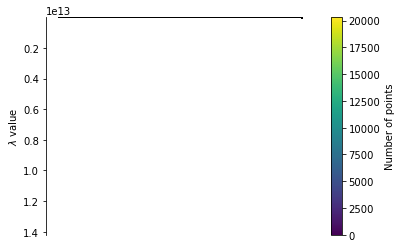

In [916]:
clusterer.condensed_tree_.plot()

**[From DBSCAN FAQ](https://hdbscan.readthedocs.io/en/latest/faq.html)**
> **Q: Most of data is classified as noise; why?**
>
> The amount of data classified as noise is controlled by the `min_samples` parameter. By default, if not otherwise set, this value is set to the same value as `min_cluster_size`. You can set it independently if you wish by specifying it separately. The lower the value, the less noise you’ll get, but there are limits, and it is possible that you simply have noisy data. See _min_samples_label for more details.


In [917]:
clusterer = hdbscan.HDBSCAN(algorithm='generic', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, #memory=Memory(cachedir=None),
    metric='cosine', min_cluster_size=5, 
                            min_samples=2, # changed this
                            p=None)
clusterer.fit(X_transformed)
clusterer.labels_.max()

774

In [918]:
np.unique(clusterer.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176

I was able to reduce the samples in the noise to 11k. This is the lowest I've gotten. The problem is, I have no idea what I'm doing! Some things that worked are:
* cosine metric, and the only way to not error out was algorithm="generic" instead of "best" 
* Smaller min_samples without changing min_cluster_size. Why did this work? I don't quite get the difference. 

# K-means

In [844]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=100)
km.fit(X_transformed)
labels = km.predict(X_transformed)
centroids = km.cluster_centers_

In [846]:
for i in range(len(labels)):
    print(protein_name_full[i], labels[i])


Q53HV7 95
A4UGR9 43
P09529 50
P19622 0
Q9UPU9 0
Q9UHI5 7
P29034 70
Q8TDM0 90
Q9HCL3 17
Q2I0M5 10
B1ATL7 40
Q9Y639 0
Q96EU6 9
Q13247 51
O15162 49
Q15413 44
Q14596 32
Q86UP9 19
Q5T4F4 83
Q5TH74 70
Q8IWF6 0
P0DP57 43
Q9Y3Q7 39
A0A494C1R9 4
Q6NT89 20
Q93034 2
Q8IZT8 32
Q6ZSR6 77
Q5VUJ9 83
Q5JXB2 99
Q8NGX5 35
Q9Y6M5 41
A6NCW0 17
Q86UP3 49
P52569 19
Q9UHP7 70
Q8N2Z9 20
Q2MJR0 83
Q9Y247 19
O75445 17
Q13057 1
Q6ZNA5 43
Q96BW9 61
Q8N135 4
Q8IZ20 94
Q5VZ72 89
Q8N1K5 77
Q5XLA6 1
Q8J025 96
Q96DB9 46
Q9H213 63
Q92830 97
A0A087WUL8 54
Q9HBT6 89
P0CF74 27
Q9H0L4 3
Q96C57 89
Q9UER7 0
Q9BT49 19
O43914 99
P01148 92
O60330 11
Q9UK39 27
P25054 89
Q96KN8 89
Q8WZ42 0
Q92805 9
P12838 17
P33241 80
Q5CZC0 19
Q9HD87 54
Q86X29 92
A0A494C162 50
Q9HD34 65
Q5VT06 11
A6NFI3 2
P53673 45
Q10570 3
Q96DU7 94
A8MWA4 89
Q14240 10
Q8IVW6 43
Q92882 19
P42345 67
P14649 6
P25398 36
Q4LDE5 16
Q99767 53
P47813 50
P28072 69
Q5VT66 52
O43422 20
Q96NT1 32
Q8IZ73 2
Q8MH63 45
Q9Y3R4 92
Q9UKU0 94
O60336 86
Q9Y5F0 60
Q5XPI4 27
Q6UX72 

Q8N6W0 25
F8W1W9 49
Q8NEC5 2
Q9Y6G3 19
Q16587 36
Q9UJ78 10
Q8WWY6 19
Q5VT40 51
A5PKW4 30
P49223 50
Q6X4W1 11
Q15024 2
Q13363 19
P0DP04 78
P02745 5
Q14517 0
Q15311 27
Q9ULL4 17
Q6S9Z5 30
Q8N1G1 68
Q6N022 50
Q8TAP8 40
Q9HC84 0
Q8WW12 89
Q9NYQ6 68
Q86TE4 1
Q6ZTR5 17
A0A0X1KG70 27
Q9Y566 41
Q9Y5H9 89
Q14865 27
Q8N3Y1 89
Q5T4S7 13
Q9UJ98 32
Q9Y263 6
Q9Y580 13
Q6UX98 49
Q9H0E2 83
P00374 3
Q9NZH7 43
Q6P5W5 81
P35789 77
Q86WK6 10
Q9NZH6 22
Q8WXF8 81
Q6UXT8 7
Q9HCD5 36
Q2V2M9 2
Q8TD57 2
P43004 77
Q9Y281 70
P53701 43
Q9BXU1 50
Q15008 17
P36406 73
Q7Z2G1 17
Q9Y4F1 99
P0DN84 18
Q9UPZ6 80
P42285 46
P0CB48 43
Q49AR2 70
Q92541 54
Q16526 2
H3BPM6 77
Q68DA7 55
Q2LD37 19
Q6V0L0 30
Q2M3A8 62
O14492 36
Q8TEU8 19
P61266 1
Q8N4W6 17
S4R3Y5 77
O00194 54
Q4U2R6 25
P10914 36
Q6ZUT9 0
Q68DL7 54
P24311 89
Q12860 11
Q8IY18 9
Q92523 17
P0C7M7 77
Q49MG5 23
Q9BYG4 17
P19838 7
Q8NHY6 67
O00305 45
Q7Z418 32
Q7L1W4 97
P82914 22
Q14129 51
P07476 83
P49638 17
Q9Y5Y6 82
Q92561 58
Q8TDB4 3
Q86YF9 20
Q9UPN3 17
A6NHP3 18
P78

Q9P2X8 11
Q8TEQ8 42
Q9BSG1 77
Q96DU3 10
Q2M2D7 2
Q15391 20
Q9Y2V7 61
Q2MV58 77
Q8N6T7 46
P62072 54
P0DTE7 11
Q9ULQ0 66
O75526 32
Q6DKK2 89
P14598 73
Q9NSA0 99
P20073 33
Q7L266 89
Q99607 52
Q9GZX6 89
Q9NZQ8 34
P0DPD5 70
Q9Y264 10
P62851 17
A0A1B0GU29 68
A0A0C4DH73 20
P31949 38
Q8N127 90
Q8WW22 61
Q9NVF7 27
Q9H354 17
Q5TZ20 92
Q15916 41
Q16739 45
A8MYU2 86
P46109 77
O60674 50
Q9NPL8 12
Q9P1U0 17
Q8WWF6 40
Q9BZD7 14
O60443 2
Q9H7P9 30
Q8IVU3 50
Q8TE12 60
Q8NET1 2
Q14236 85
A6NJ64 0
Q9H252 2
O75582 2
Q5H9K5 12
P0DP58 19
Q14318 69
Q9UBT3 73
Q9NZW4 40
O00219 89
Q53FZ2 77
A2RUB6 23
P11226 2
Q86YN6 99
Q5SWL8 50
Q5SGD2 15
O75473 83
O95391 22
P15918 70
Q9UBG0 32
P0DPF4 79
Q9NWQ8 59
Q6P4Q7 19
Q9Y3B6 54
P11047 43
P01730 17
Q6QEF8 9
P56559 94
P29084 25
Q96BZ9 2
P02533 32
P29374 17
Q96RU8 89
P02750 12
P30050 22
Q9NX38 48
Q8TE77 87
Q9HAC7 7
O95568 43
Q9UNY5 78
O43314 45
Q5T1M5 7
O43396 17
Q8TBF5 58
O00421 3
Q9Y366 61
Q9H869 54
Q9NZT1 19
Q14210 96
Q7Z2W4 69
Q9BRA2 89
Q9HA92 66
Q9NYS7 82
Q9UIL8 13
Q9UB

Q9HBE5 85
Q13950 50
A6NM62 19
O43290 50
Q96EY1 99
O15204 0
Q0P651 4
Q96FE7 18
Q9Y4E6 51
P30519 94
Q9P2V4 33
P36543 22
Q9BZI7 83
Q8NAV2 2
P0DP07 99
Q8IXS6 5
Q96PS1 83
Q9UL41 63
Q86V87 4
Q14241 32
Q53RT3 50
P11836 0
Q8NCT1 17
Q8N139 27
Q15067 77
Q8N1Y9 18
P50453 68
O00322 71
Q9BX84 92
O14976 19
Q86UY6 89
Q8N5G0 97
Q9C0B1 11
P08922 18
Q9UM11 13
Q5TFE4 13
P0DMN0 77
P08237 77
Q99807 43
Q8WW43 33
Q1MX18 83
Q92598 6
Q9Y2Q0 77
Q14533 77
P63172 17
O95602 11
Q32P41 70
Q2TB10 78
Q13509 45
Q92185 82
Q13564 97
Q13438 48
Q9H9S4 2
A0A494C0N9 95
Q9P0N8 2
O00625 17
P80075 58
Q6P1L6 39
Q8NEG5 10
Q9Y3Q0 50
O75914 77
Q6ZS27 12
Q9H4G4 10
Q86WT1 32
Q6XR72 73
Q99653 17
P49459 55
O96008 35
Q9Y6S9 44
Q14258 7
Q86YS3 17
Q6PJE2 17
O14653 20
Q9HCE1 83
Q9H0K6 43
Q96RQ3 49
Q53S08 1
O60930 25
P98177 12
P17813 0
Q9H3Z4 64
A0A0B4J1X8 70
Q8TCV5 5
Q8N7X8 57
Q5TA78 83
P01033 80
Q7Z7G0 69
P55210 89
P17020 82
Q9UHU1 10
Q96QE2 61
P0CJ70 33
Q504Q3 62
Q9UBY8 60
P51681 24
Q8NFM4 61
Q9NP91 18
Q9H1P6 70
Q8IUE0 20
Q8IXR5 68
Q9BQW

P47887 61
Q5W150 61
Q9H9P2 36
Q6UB99 51
A0A1W2PQ72 50
Q6ZST2 2
Q8NGZ3 97
Q5TAT6 41
O43166 19
Q63HQ0 50
Q14588 2
Q9Y3F4 10
Q86SE8 13
Q8IY63 58
Q5XKL5 17
Q86SM8 4
Q9BQ75 61
Q8N3V7 7
Q8NH59 50
Q12884 41
Q5T0N1 94
P22459 73
Q9HCM3 2
Q15937 50
Q9H1K1 45
Q9UMQ6 12
P15559 93
Q5T013 82
Q9BXJ7 21
O76099 22
Q9NVC6 61
Q9NW68 18
Q9NRM2 2
Q5HYW2 54
Q8N9B8 50
Q8WWZ7 6
B1ANS9 77
Q13772 94
E5RJ46 2
Q16623 80
Q495M9 17
E2RYF6 19
P10997 22
Q6P1Q9 11
P0CK97 7
Q5VT03 2
P50454 50
P08151 71
Q96T23 89
O14917 89
Q8TEW0 27
P0CJ72 50
Q96NU1 70
Q9NZP5 50
Q96EZ4 41
O75157 53
Q5HYW3 50
Q9Y6U3 17
Q92839 79
Q9BRR9 77
Q08752 54
Q8N119 73
Q9Y244 76
Q5T7W0 96
Q8NBS3 19
Q9BY66 54
A0A075B6H9 54
Q9H963 5
Q5JQF7 10
Q9BWH6 20
Q96L03 6
Q9Y2B2 17
Q9H061 86
O75718 61
Q86WP2 77
O15060 0
Q6ZVD8 45
Q9UM07 22
Q9HCS4 58
Q9C0C2 50
Q5T6C5 89
P82930 50
Q6UWM7 63
P0DPE8 82
P48200 83
Q9UNA4 43
Q8WVE7 7
Q8IV16 83
A0A0C4DH62 0
Q8TDV0 50
A6NHJ4 24
Q99426 10
Q8N5C8 70
P20853 19
Q5T4B2 62
P63146 43
Q3KQV3 35
P83111 10
Q3LI72 54
Q8N392 42
Q15

O00299 68
P02724 32
P60953 51
Q9H161 25
O95931 50
Q13072 50
O95716 17
Q5TGY1 47
Q8IVG9 77
Q9GZY0 68
P30281 7
Q6GMV1 6
P51665 21
P02795 83
Q68DI1 58
Q6PJT7 10
Q9UN37 89
Q53RD9 77
Q96LA5 20
Q5U5X0 9
Q9Y5L4 92
Q96T52 11
Q96SF2 97
A0A0A0MS00 86
P04040 29
P11274 32
Q7Z3G6 2
Q96A26 89
Q96MN2 83
Q9P2T1 15
Q96H35 21
A0A087WW87 49
P83105 29
A8MZA4 87
O15375 17
Q6P589 33
Q14003 14
P09237 2
P0DMQ5 76
Q96CK0 20
O76002 45
Q05952 41
Q9H0T7 63
Q8IWN6 47
P29376 89
Q5TGY3 12
Q9Y2G3 89
P15407 77
Q8N9E0 2
Q9GZK4 2
Q9NZD2 41
P04049 14
Q92949 12
Q8NHW4 0
Q63HN1 85
Q9NTJ3 99
Q9HD23 17
Q15075 17
Q9HBM6 17
Q92908 99
Q12965 89
Q8NCD3 18
Q5JRM2 19
Q9BV44 19
Q8TB69 43
Q86X40 10
Q5T5U3 22
P56706 89
A4D0T7 83
Q9BR26 17
P00915 17
Q9BQQ3 30
Q7LGA3 89
Q5JT82 77
Q15011 19
Q9NQ92 54
Q9NYL4 68
Q9NRI5 51
Q9BT25 2
P98174 2
Q9Y287 19
P29373 20
Q86V97 37
Q5VWQ8 94
Q8WXD2 2
Q16790 54
Q9H9A7 30
Q07092 50
P11464 89
Q96QT6 9
Q96S16 19
B2CW77 58
Q9C0I4 0
Q8NGV6 46
P03956 24
O75106 76
Q6UXT9 30
P0DP09 86
P57729 38
O95158 25
Q2M2W

Q12952 17
P21452 0
P60604 61
Q9Y4L1 35
Q15468 77
P09234 50
Q8N1G2 20
P02763 54
Q96BW1 44
Q96LZ3 68
Q8NGS6 55
Q8WVF2 24
P22033 83
Q5VWQ0 82
Q8WWZ4 89
P16885 77
Q9BZI1 1
P18827 0
P49675 89
A0A0C4DH43 17
B1AKI9 5
P59537 19
P61578 61
Q9H342 65
P01763 41
P0DMQ9 5
P50120 63
P08684 37
Q96BR5 62
Q12901 73
Q86VD1 10
O60237 2
A0A075B6N2 19
Q711Q0 59
Q9UDY6 89
Q7Z572 17
Q9BZC7 99
Q96CS4 77
Q9Y466 10
Q8N8Z8 34
Q05066 10
Q5TYW2 36
P0C7U0 17
P59090 22
Q6NW34 11
P43246 24
P42677 77
A0A024RCN7 85
Q9H008 8
Q96LI6 23
Q9H2D6 0
Q9UGK8 50
Q96Q89 13
Q9NP95 17
Q9Y585 81
O75717 41
Q9H6D3 13
O60573 61
Q16204 49
Q16515 17
P32745 51
O00626 24
Q15165 85
Q9NRG1 94
Q587I9 31
P02812 51
Q16611 89
Q9HAV5 11
Q9BRK5 2
Q5HYJ1 96
Q8N136 77
A0A075B7D0 13
P00746 5
Q8ND71 26
Q9Y5G2 25
Q5UAW9 27
Q96PI1 61
P34741 42
P0DPQ3 51
O14709 0
O43511 10
Q56UQ5 77
Q02413 34
Q9UGP4 64
P48668 50
O95631 17
Q8WV74 1
P60014 72
O75949 0
P0DN79 2
O75150 78
Q6WBX8 17
Q9UPC5 46
Q9UK28 24
Q92522 2
Q8NHY5 0
P13671 46
P0DSO2 46
A6NMZ5 8
Q08830 41
Q

Q5MJ07 93
P25445 42
Q15493 20
P05787 94
Q9UQ05 17
P58173 2
Q9H2J4 41
Q0VAA5 48
Q9UI47 82
Q9Y4D1 14
Q14914 17
P00325 78
P51810 78
Q9UBK2 61
Q9ULK4 50
P28566 6
P51955 61
A0A1B0GTH9 2
P30530 65
A6NF89 9
O94913 41
Q4VXF1 50
Q96P26 63
P0DI80 7
Q96AJ9 16
Q9Y5W9 83
Q9BYC8 0
Q3KR16 63
Q8N5N7 18
Q8NGA4 36
P83876 24
O60234 66
O94778 43
Q7Z4I7 11
Q96NA8 40
Q9Y2B9 17
P10074 42
Q8NEE0 10
P22223 11
A6NM03 27
Q8WXK4 41
Q16514 67
Q96A83 99
Q07326 50
P05121 61
P22314 71
Q96JP2 43
P82933 19
Q15831 51
Q9Y2M0 12
Q8NGG8 7
Q96J87 41
Q8WZA1 49
Q9NXC5 86
Q2KHM9 13
Q14679 2
Q9Y251 89
O14625 82
Q96TA2 85
Q8TE58 2
P84077 46
Q14344 47
Q14162 20
Q8TB40 40
Q5VTT5 86
Q8N6U8 9
P0DN37 17
O75665 87
P29371 17
P10645 61
Q008S8 2
Q9Y5T5 18
Q86YM7 54
Q8NFU0 17
Q15181 99
Q9Y3M8 54
Q6ZW33 54
P48060 19
P43307 86
P01611 30
P58549 38
Q8NBM4 11
Q9BSE4 54
Q02487 99
Q96QZ7 27
O15225 50
Q96IR3 19
Q5T7N3 77
O75367 19
Q15884 4
P10599 2
Q9H4K1 66
Q96JN0 17
Q8IYA7 89
O14656 99
Q04721 48
P51582 40
A6NGY5 61
Q9H6E4 24
P46093 33
P67870 61

Q969V3 89
Q16665 86
Q6Q8B3 19
Q9BZ98 9
Q5R3K3 28
P49765 17
P04080 46
O94813 46
Q5T2E6 22
Q9HD90 6
Q9Y265 99
P0C6P0 4
A6NKC9 65
Q8WXS5 50
Q96T51 97
Q8NCQ5 17
Q969E3 54
Q12929 63
P09912 18
Q8NHS0 20
O43295 50
Q8WV99 17
P48357 45
Q9H3C7 30
P11597 2
Q5VSG8 20
Q13639 77
Q14296 61
Q9GZZ1 95
Q9BQY4 74
Q15057 63
Q8NGK1 17
Q5T655 61
Q86WU2 17
Q9BQS8 43
P07195 17
Q9NQ40 21
P15173 33
Q16342 70
O43189 87
Q9GZR7 50
A6NEW6 7
Q8N292 89
Q8TBZ6 97
Q8N1V2 20
Q6P1K2 13
O95677 83
P15336 89
O75309 2
Q96H55 27
Q9UJW8 17
P05496 45
Q06416 51
Q9H6X4 50
P26441 51
Q7Z7B0 83
Q8IX15 17
Q13342 50
A0A2R8Y4Y8 89
Q8N9B4 9
P07108 67
A0A0G2JNH3 85
Q9NNX6 41
Q9Y5F8 32
P49959 27
P49190 30
Q9NRR6 17
Q17R89 89
O00541 2
Q86UV6 77
Q9NRD8 17
P0DMU9 18
Q86SF2 63
Q13454 86
Q9Y272 83
O00519 47
P0C7X5 83
Q14728 10
P40879 33
P28749 77
Q8NGC0 32
Q9Y3M9 24
Q8TDC0 10
Q9NP08 63
Q3ZCQ3 99
P01733 51
O94769 5
Q96BM9 22
P25685 47
P0DUD2 27
Q8IWZ4 93
O95072 17
P20062 19
Q8WYQ9 6
P54802 89
A6NIH7 48
Q12841 27
Q07866 97
P13797 17
O15084 4
Q96

P51532 2
Q9BUF5 2
A8MWX3 79
P50406 99
Q06136 61
P11465 91
Q14439 9
A0A0B4J2E0 17
Q9NS84 75
P17050 97
Q8WXH2 21
Q3KNV8 2
O95801 51
Q8IVH4 4
Q15040 54
Q6P1M9 35
Q8IZF2 89
Q8IZ83 30
O94983 23
Q7Z3T8 19
Q9BYZ2 89
Q3KQV9 43
A0N4Z7 32
Q14195 63
Q8TCT7 21
P54821 77
Q6NUM9 99
Q9ULW5 77
Q9NVE5 25
Q9UPM6 30
Q9UBB5 1
Q8N436 0
Q9H0D2 50
A0A286YF58 89
Q9NQR1 17
Q9H2G9 0
Q5CZA5 17
A6NDK9 10
Q86VZ6 17
Q9UKP4 45
Q9H7F4 46
P52294 14
Q9BYQ6 95
P86434 45
Q7Z2Z2 75
Q9Y4Z2 32
O60784 99
P0CJ68 32
Q9Y6Q5 92
Q86YD1 27
Q8N8P6 89
O60942 20
Q9Y2F5 48
Q6ZMV5 19
O95390 6
Q96EE3 19
Q15915 94
Q6PUV4 45
Q9H228 20
P19404 24
Q9NUM3 95
O15197 17
Q9UGJ1 30
Q86XS5 70
A0A0U1RRE5 17
Q8N137 42
Q86UF2 17
Q6W4X9 17
Q9UKI9 89
P14415 0
G5E9R7 20
Q8IUR0 68
O00602 77
Q9Y4C4 81
Q6NUS6 22
Q9Y5H6 46
P51164 27
Q96EM0 20
Q17R98 74
Q9H9J2 50
Q14746 70
P62888 77
O95881 85
Q9BY19 82
A5PLL1 92
P29083 89
O43826 99
Q16322 33
Q6PJ69 70
Q6PIV7 17
Q13015 61
Q9P1Y5 42
P16152 2
Q9C0D4 91
Q4KMG0 89
Q13303 9
Q96A29 21
Q7RTS3 70
P52895 2
O00548 78
P

Q16651 51
Q96GL9 87
Q9UHQ4 97
Q7Z7F0 17
A2RRP1 50
Q8NGH5 4
Q96ID5 41
Q9H0J9 27
O15209 1
Q9UBX5 50
A0A3B3IU46 40
Q8WTW3 63
O75915 77
P01562 92
P0DN86 34
Q6RI45 46
A6PVS8 60
Q7Z4H8 17
Q92613 23
F5H284 2
P60763 87
Q9WJR5 25
P18825 48
P15313 83
Q9HBI0 4
Q8WZ26 4
Q9HCM2 83
P03952 30
Q8TB52 3
Q05C16 19
Q8TB36 22
P51608 77
P78352 0
Q9C029 7
Q12794 17
Q66K14 82
Q96G61 32
Q5TA81 72
Q6ZS11 80
Q08357 32
Q14444 70
Q05940 19
Q8NBP5 33
P27338 33
O00505 1
Q00005 95
Q86Y78 94
Q96GQ5 39
A6NDU8 33
O95319 14
P55263 49
Q8TBZ9 23
Q8WXG6 34
O94844 7
A0A286YF46 4
Q05639 8
O43895 4
Q8IZJ6 18
Q9H5J0 16
Q86U06 50
Q8N5C7 49
P01599 54
P48556 38
Q13003 6
Q8TB05 70
P51530 63
Q8NG78 43
P27449 24
Q8N9B5 18
Q9H974 17
 21
Q96KG7 13
O15117 40
Q8WUM0 50
Q52MB2 32
Q9H2A2 2
Q8IZE3 23
Q9Y216 89
Q7Z7G8 2
Q9BY42 30
A6NHN6 1
Q8N5M9 2
Q92928 83
Q7RTT9 25
Q9NPH0 33
P49888 32
Q86T26 77
A6NC62 97
A6NM28 80
P46976 10
Q9NXD2 86
P43629 32
Q86YR6 9
Q9H6H4 19
Q9BXP5 17
P05026 54
Q5VZ66 20
O95153 17
Q6V1P9 2
Q7Z3S7 27
O15460 19
Q8NAN2 8

Q08170 58
Q9BRQ5 89
P04211 17
P11230 29
Q641Q3 19
A0A2R8YEV3 58
Q9BZW4 41
Q96EF6 14
Q9NY30 58
Q9Y6Q1 11
P47985 58
Q14CS0 99
A0A5F9ZHI8 63
O00193 50
Q9GZT8 99
Q7Z2K6 49
Q9H503 32
Q8HWS3 85
Q15046 19
Q9UBC3 20
Q9NQ87 19
Q92765 19
O15041 18
Q6ZR85 60
P08729 92
P63132 17
Q14802 48
Q6ZR08 11
Q8TC59 48
Q6ZTB9 7
Q9H0I3 10
P43358 17
Q9NY57 93
O75185 98
Q9H579 70
P57088 6
Q8IYB0 14
Q9HCK5 0
Q9H3P2 43
Q8N912 50
Q14028 99
P28715 2
Q9Y5W3 19
Q96DZ5 0
P28360 67
Q9BQA1 99
Q8N8G6 13
O14497 20
O95684 89
A0A087X1L8 19
P03905 51
P48051 14
P61081 97
Q8NDX6 35
P34896 45
P54792 77
Q8WVI7 89
Q5JXM2 80
Q96T58 97
 50
P10966 98
P60331 51
A0A0B4J1Z2 0
A0A075B767 29
Q9NY46 87
Q5TFG8 70
Q92583 99
P13798 85
Q99543 94
P51508 17
Q96QP1 10
Q8N344 89
P05023 0
Q9GZQ3 18
P21741 32
Q96BN2 46
Q7Z4T8 51
Q9BZQ8 86
Q8WYR1 2
Q9H875 32
Q8NE31 92
P00995 19
Q96MU6 85
Q14005 10
P11912 89
Q8NA03 17
Q9Y4Z0 2
P28332 89
Q13131 78
Q96F63 12
O76071 20
Q7RTM1 94
Q8IVV2 70
Q9NR30 27
Q96MK3 7
Q96LK0 97
Q05925 4
O95183 0
P63252 92
Q2TAA5 9

Q5S007 79
Q8IVC4 22
P53618 10
Q01538 95
P36959 2
A6NDX4 21
P01111 11
Q9BRT6 25
Q7Z692 97
Q86W54 2
Q8IVF5 83
Q3LI63 19
P62945 50
Q14957 1
P04818 19
A0M8Q6 43
Q9Y6X3 3
P62256 73
Q8TES7 35
Q14554 17
Q9NTX7 66
Q9BSU1 89
Q9BR84 40
Q3B7I2 10
A4D1Z8 42
Q9UKT6 57
Q9BUM1 15
P25092 33
P02656 77
P20648 92
Q5JVX7 18
P46736 19
P47893 63
P30793 61
P0DUD3 93
Q8WXX0 93
P83731 77
P60059 51
P07998 11
Q4V321 11
P41247 68
Q96I15 99
Q9UFD9 77
Q8N9N2 2
Q9H467 12
Q96PB1 77
P21730 77
Q96JD6 61
P56202 31
Q6ZNG0 43
Q9BTT0 10
Q8WWA1 22
Q9P2F6 0
O95263 89
Q9Y3M2 7
Q5TCY1 65
Q9ULF5 50
Q16880 2
Q9NYY8 23
Q9P0W0 95
P02776 83
Q6ZSM3 39
Q9BV81 33
Q9BT43 92
Q8TE60 99
P20591 46
Q9NZM1 17
H3BUK9 3
Q8NH16 19
Q9H1H1 41
Q6P1Q0 10
Q96RJ3 70
O75808 2
Q96M86 50
O00470 77
Q9NZ71 2
Q7Z5L3 32
Q8TDS7 0
O00370 61
Q9NR23 77
Q86SY8 19
Q9H341 86
P07942 24
O95718 17
Q8IZJ0 93
Q13232 34
Q7Z6K1 34
Q9NWS1 51
Q15697 19
Q9P2N4 19
Q8WVX3 46
P81172 42
Q9NQG5 11
Q8N608 83
P0C6A0 94
Q9BYR7 0
P56851 80
O94956 97
Q8NGI0 70
D6R9N7 61
P78348 49
O95

Q8IW50 92
Q9NQB0 68
A0A075B6S0 50
Q5VYV7 0
Q03924 50
Q96H15 10
A8MT70 89
Q5TGU0 19
Q15370 14
Q495N2 8
Q96E16 70
Q5TCH4 92
Q96G30 62
Q9UNS1 20
P62891 32
Q9GZS0 77
Q14943 60
P21695 9
Q6AWC8 48
Q9GZV1 81
A8MWL7 19
A8MX80 92
Q8N5S3 0
Q96LX8 0
Q9P1Z9 10
Q8N6Y1 17
P43489 27
Q8N461 51
Q7Z4G1 15
Q16513 28
Q8N9K5 18
P58181 10
Q8N201 41
F8VTS6 6
Q8NHB7 60
Q9NRF9 41
P08727 83
Q9UQ35 17
Q400G9 89
Q9NQX6 7
Q9HB96 10
Q8NGA1 95
P00367 41
Q96CW6 86
Q8N5S1 0
Q9HCJ5 61
Q6ZT62 6
Q9GZM6 17
Q6ZTI6 41
O94766 0
O75334 86
P00966 17
Q6P3W2 43
O60423 11
A0A494C193 70
A0A0B4J2E5 65
Q9BZW2 13
Q5W064 70
Q86VP6 86
O15482 95
Q9HAR2 17
O76009 60
O15143 17
P50135 13
P30872 31
P57053 24
Q96GU1 65
O14556 36
Q9NZG7 7
Q6UWN5 83
Q9BYD1 69
Q9NTQ9 32
Q9Y4B5 83
Q9HCU5 2
P43699 94
P17542 50
Q92748 2
Q9H6K4 51
Q52LR7 92
Q7RTT3 19
P21127 97
Q6AZW8 2
Q8N766 10
Q13573 94
O95873 2
A6ND91 19
Q12931 78
Q9Y6N9 54
Q96KM6 17
Q8NGS3 22
Q8N431 61
Q9NWT8 6
Q8TC07 51
Q8TB68 7
P37268 2
Q01959 48
A0N4Z3 70
P10911 35
Q9Y615 18
Q9Y2H1 93
Q8NDZ4

Q9HBB8 7
P61960 27
Q96PM5 8
O60828 13
Q03181 70
P51790 93
Q9UJ94 70
Q15025 92
Q8N9T2 17
Q9H074 68
P13984 6
O95007 30
P25098 41
P02647 32
Q9BUB4 17
Q96T59 54
Q9UJQ4 99
Q5K651 19
Q13323 48
P0DOY3 17
Q92636 3
Q8IXM2 13
Q8IXW5 83
Q8IXZ2 19
Q96GX8 50
O43660 42
Q9H4I8 13
P17516 86
P49450 78
P25103 34
Q9HCN4 61
Q6ZU80 77
Q8N2G6 17
P07199 99
P04626 32
Q5SW96 64
Q9NVD3 19
Q8WZ79 4
O75631 87
Q9H1E1 51
Q86TB3 11
P41252 89
O00213 32
O14776 19
P00751 2
Q9H665 82
P57055 2
Q9H756 68
Q9H1F0 22
Q5T3I0 85
Q02641 50
Q8NGA5 54
Q9H9D4 41
H3BNL8 45
Q9BZL4 17
Q9UBB9 19
Q9H808 2
O95219 60
Q5D0E6 17
O76082 48
Q6ZN06 33
A0A2R8Y4M4 10
P48059 55
K9M1U5 40
Q9P2E8 34
Q8NBE8 2
Q9P0K8 94
Q96AT9 50
Q8IWE4 21
A9QM74 93
Q6P0N0 95
Q6UY01 50
Q9NPC1 15
K7EIQ3 61
Q96F24 80
Q9BY49 17
Q8N9Z0 91
Q96IL0 10
Q96HG1 83
P78563 11
A6NI61 54
P05156 14
Q6N043 87
O15054 50
Q14019 89
Q9Y4W2 43
Q13188 32
Q3KRB8 70
Q96LR2 24
Q8N720 2
O60504 10
Q5T6X4 50
Q13098 99
Q99877 73
Q15287 65
A1IGU5 0
Q7Z449 17
Q12891 62
P47871 82
Q9H0J4 17
O60755 

Q5VXJ0 91
O00214 86
P82921 57
Q3LI62 42
Q03426 2
P0C263 48
Q8WXF1 12
B0YJ81 2
P41968 14
Q9BXX2 61
O15034 2
Q9HAU5 2
P34932 32
Q86XP3 77
Q9Y679 7
O14994 77
Q9BTP6 89
O14511 51
Q9BXT2 19
Q7Z553 83
Q9UJ42 9
Q8IWZ5 61
Q9P299 2
H0YL09 36
Q96GZ6 35
Q8NGC2 24
A0A183 41
P03973 28
A7E2V4 3
Q13309 7
Q9UJU5 64
Q6YI46 50
P55201 17
P12645 19
Q9H8S5 0
P61020 93
Q96NY7 47
Q9NY72 22
Q9BYG7 51
P0CJ85 95
Q96PT3 7
Q5T9A4 96
Q96FQ6 17
Q96R09 90
P02686 41
Q9HCJ3 0
Q9HCH5 89
Q7RTR2 50
Q5VT97 15
Q9Y6F9 89
Q5XUX0 83
Q8NF99 2
Q92922 10
Q9BPZ7 2
Q8NFH5 12
Q15782 0
P09038 82
Q8NDP4 81
Q16540 10
Q96RT7 28
O60487 2
P02100 51
Q8N7M2 34
P55285 10
Q16740 27
Q9Y258 15
Q9H2S6 85
O15063 97
P35237 19
A6NIY4 71
Q6IS14 99
Q8N141 81
Q8NC96 10
A8K0R7 19
P0DMV2 50
Q8N8I0 63
Q8NGC5 51
P55895 61
A0A075B6N1 94
Q92621 5
P30049 32
Q9NPB8 69
Q86TS7 27
Q12829 49
Q9NPB0 47
Q9Y520 99
Q6NVV1 50
Q14330 65
Q17R60 61
O43663 7
Q96G21 17
Q8NHA8 83
Q9BSY4 61
P06132 14
Q9NS62 6
P53041 50
Q9Y6J3 4
O00409 28
P48048 0
Q9UL25 97
Q6P1J6 47
C9JFL3 

Q9H1D9 83
P17787 62
Q86WK9 19
Q9BZ29 14
Q9UGM6 32
Q3MJ40 4
P0DN81 2
Q7RTN6 41
P41732 98
Q86U17 92
Q16658 71
Q8NFG4 81
O00186 2
Q8WXC6 77
Q8N6D5 43
Q9Y4A9 67
P51843 41
Q9BYC2 99
Q4KMG9 31
Q68EM7 83
A0A0J9YXX1 19
O14841 5
Q9H8T0 77
Q8N9L1 99
O14576 19
Q8IVW4 60
A0A1B0GTR4 89
P28676 80
Q9GZX9 96
A8MT69 93
Q8N715 11
Q92859 17
Q9BXA7 9
A8MX19 98
Q92551 89
P01766 7
Q8WZA9 5
Q969F2 25
O95786 0
P43119 77
A0A075B7E8 61
Q9BSF4 5
Q96NS5 83
Q1RN00 67
P57054 36
Q15386 20
Q8WUX9 32
P14780 77
Q70HW3 76
O43159 61
Q8IYB1 19
Q99999 77
Q9BX97 77
Q8N8Q1 17
P59861 14
Q14954 85
Q9NZH4 9
Q9BXY0 0
O43759 2
Q63HM9 17
P03923 21
Q8NCH0 14
Q8TEE9 97
Q99490 36
Q9C0K3 50
P48454 96
Q9NNX1 86
Q9BSK1 17
Q96PD7 10
Q8TB45 83
P29033 2
Q86V42 17
O95470 0
P02778 97
B1AK76 39
Q01628 35
Q3SXY8 51
Q59GN2 70
Q9P0K7 50
Q9H6S0 17
P41238 4
Q9BXJ8 21
A8K0S8 83
O60239 32
Q8IW45 17
Q8N2N9 86
O76039 17
Q29983 89
Q6ZWJ8 88
Q5VVQ6 40
Q8IVF1 75
O14512 50
A0A075B7D4 89
Q9NQ39 38
Q92831 59
Q96A25 54
Q9BWM5 99
Q96IW2 10
Q96A22 0
Q6ZNW5 68


Q96LA8 11
Q8WU90 86
Q7Z6P3 99
Q969U7 2
O75368 8
P07900 66
Q9H330 54
Q99829 17
P43626 3
Q8N0U7 9
A3QJZ6 0
P11245 15
Q9BUY7 37
Q6ZV89 70
Q03828 19
Q96S86 50
Q99932 1
O15211 19
Q8IUQ4 32
Q96FK6 57
P11277 94
A6NNE9 18
Q9UPY5 2
Q6ZUG5 70
Q9NX63 54
Q53QZ3 17
Q9UKX7 54
Q86X19 50
Q96RJ0 83
Q969K7 61
Q9BRS8 83
Q6NWY9 0
O94827 2
Q8NGS1 19
C9JLW8 41
Q8N7A1 20
Q8TEH3 94
Q6ZN17 50
P20742 69
Q05193 27
Q8TD16 70
Q9UMR2 17
Q92743 43
Q3ZCQ8 87
P41161 77
Q96EY8 19
A1L3X0 33
Q9Y4C2 24
Q96HU1 23
P03979 77
O75044 5
Q8WTZ4 17
Q8WYN3 0
Q8WV60 50
P04118 95
A8MUU9 39
Q9BU19 50
Q3MJ16 45
Q9BXU0 3
P15498 92
P11509 18
Q5BKU9 62
P62324 36
Q96B26 11
Q8WY91 32
P01703 2
Q96PD4 29
Q96ME7 97
Q9HCF6 45
Q9Y4U1 19
E5RIL1 48
Q9GZR5 51
Q14247 61
P0CG20 2
O14957 50
Q9P1Q5 6
Q7RTY9 41
Q8NHC5 87
Q86VR7 41
Q9P032 30
Q8TDD5 65
O00139 17
Q9UHG2 83
A0A1B0GWB2 2
Q8IUR6 51
Q9UJU3 50
A6NI28 45
P22307 17
Q9NY65 48
Q8N6K7 82
Q9P2K3 4
Q96T68 54
O60641 50
Q8WXE9 89
Q8WYQ4 89
A6NJQ4 8
Q9BTY7 89
Q9UM44 95
P0CI01 9
P23771 99
P11049 89
Q96IX

Q16850 36
Q14993 62
Q6NXN4 89
P08123 2
P55851 89
Q99755 61
Q9UHP3 0
Q9Y5A7 70
Q8TAE7 4
Q6UX53 70
A2RU48 31
Q8IUC0 83
Q6NUN0 0
Q8N8L2 23
P42680 10
Q07011 35
Q6UX39 2
P05160 0
P43364 53
P61599 7
O60238 74
P05187 36
Q6ZWJ1 18
Q9UKX3 17
P10092 17
P07093 92
Q3SY17 71
O00198 61
Q5SWX8 11
O43677 32
P16035 42
Q96EE4 44
Q86UD0 83
Q5T8P6 17
P54253 50
Q01814 50
Q9BRP8 18
O43657 51
Q1ZYL8 92
Q9H8H2 77
Q9UG63 7
Q9C056 70
Q6BEB4 51
P18085 0
Q2WGJ6 47
O95236 94
P17538 2
Q8TBK2 26
Q5SQ64 48
O75508 9
Q8N1A6 83
O43598 87
Q9P2K1 43
P41222 19
P00738 44
Q96HM7 1
Q96MV8 7
O43681 83
Q5VZ46 43
O43555 89
Q9Y6X5 63
Q68CZ1 51
P34925 17
Q70J99 30
Q93091 32
Q32M45 11
Q5T601 70
Q9BY31 30
Q9P2G9 10
P62269 94
Q99750 55
Q96PS8 99
P59998 83
Q9NRR1 12
Q9H2L5 34
P25942 51
P85299 51
A0A075B6T6 19
Q6UXN2 56
Q6PIY5 89
Q86WX3 95
Q9Y462 63
Q8IWY9 45
Q3KNT9 32
Q6PEW0 65
Q8NHB8 87
Q9Y6G1 41
Q9UBZ4 92
Q8N5Y8 89
P54840 51
Q17RN3 48
Q96CW5 70
P43628 83
P17038 9
O95251 10
O43264 7
Q8N414 77
Q86TX2 51
Q9UN66 7
P42262 27
Q52LA3 70
P1

In [847]:
# run BLAST

[hypothesis] Maybe 398D is enough to predict a small number of functions. But for our big data and task, this is not enough dimensions to capture the structural information. Might be too sparse. 

goals
1. even out clusters: don't want to limit to subset (peeking at ans, not good idea)
2. evaluate

Try:
**We could try to increase dimension by re-doing this with higher D.**

Eval from three angles: 
- AA sequential sim: blast 
- function: 
    * could we just use DeepFold second half to predict function? **talk to skyler** (back pocket: GSEA) --> this is grading. 
    * COuld use functions from GSEA 
- structure: TM score